# ID5059 Knowledge Discovery and Datamining - Assignment 1

## Import Packages

In [3]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read in Data

In [4]:
# Read the dataset
# I used only the small dataset because the computing time for the selected ML model including all chosen features took about 45 minutes to compute. 
# When using the test set in the end, the computing time was significantly lower - so I guess that the computing time is exponentially increasing the larger the data set is.
flights = pd.read_csv("Combined_Flights_small.csv")

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

# Take a first look at the data
flights.head()

Unnamed: 0  FlightDate                      Airline Origin Dest  Cancelled  \
0           1  2018-09-07        SkyWest Airlines Inc.    SLC  LAX          0   
1           2  2018-06-27  Air Wisconsin Airlines Corp    ORD  ILM          0   
2           3  2018-03-14       Southwest Airlines Co.    MCO  SJU          0   
3           4  2018-02-18              JetBlue Airways    JFK  LAX          0   
4           5  2018-10-26            Endeavor Air Inc.    ROC  JFK          0   

   Diverted  CRSDepTime  CRSElapsedTime  Distance  Year  Quarter  Month  \
0         0        1953             119       590  2018        3      9   
1         0        1355             136       760  2018        2      6   
2         0        1705             160      1189  2018        1      3   
3         0        1046             384      2475  2018        1      2   
4         0        1850              98       264  2018        4     10   

   DayofMonth  DayOfWeek Marketing_Airline_Network  \
0           7          5                        UA   
1          27          3                        UA   
2          14          3                        WN   
3          18          7                        B6   
4          26          5                        DL   

  Operated_or_Branded_Code_Share_Partners  DOT_ID_Marketing_Airline  \
0                            UA_CODESHARE                     19977   
1                            UA_CODESHARE                     19977   
2                                      WN                     19393   
3                                      B6                     20409   
4                            DL_CODESHARE                     19790   

  IATA_Code_Marketing_Airline  Flight_Number_Marketing_Airline  \
0                          UA                             5563   
1                          UA                             4835   
2                          WN                             1544   
3                          B6                              423   
4                          DL                             5510   

  Operating_Airline  DOT_ID_Operating_Airline IATA_Code_Operating_Airline  \
0                OO                     20304                          OO   
1                ZW                     20046                          ZW   
2                WN                     19393                          WN   
3                B6                     20409                          B6   
4                9E                     20363                          9E   

  Tail_Number  Flight_Number_Operating_Airline  OriginAirportID  \
0      N208SY                             5563            14869   
1      N467AW                             4835            13930   
2      N7822A                             1544            13204   
3      N967JB                              423            12478   
4      N293PQ                             5510            14576   

   OriginAirportSeqID  OriginCityMarketID      OriginCityName OriginState  \
0             1486903               34614  Salt Lake City, UT          UT   
1             1393006               30977         Chicago, IL          IL   
2             1320402               31454         Orlando, FL          FL   
3             1247805               31703        New York, NY          NY   
4             1457606               34576       Rochester, NY          NY   

   OriginStateFips OriginStateName  OriginWac  DestAirportID  \
0               49            Utah         87          12892   
1               17        Illinois         41          12323   
2               12         Florida         33          14843   
3               36        New York         22          12892   
4               36        New York         22          12478   

   DestAirportSeqID  DestCityMarketID     DestCityName DestState  \
0           1289208             32575  Los Angeles, CA        CA   
1           1232305             32323   Wilmington, NC        NC  

In [5]:
# How many rows and columns/features does the dataset have?
flights.shape

# 29,191 rows (flighst) and 47 columns/features (using the small dataset)

(29191, 47)

## Split into Test and Training Sets

In [6]:
# stratified sampling

from sklearn.model_selection import StratifiedShuffleSplit

# define how to split the data
shuffled_data = StratifiedShuffleSplit(
        n_splits=1,
        test_size=0.2,
        random_state=5059 # set seed to maintain split
)

# create indexes for train and test sets
# we want a stratified sample based on year, month and disruption 
# (disruption is important because it will be our label; year and month is important because we know that there are differences due to COVID19)
[(train_index, test_index)] = shuffled_data.split(
    flights,
    flights[["Year", "Month", "Disruption"]]
)

# create train and test sets
flights_train = flights.loc[train_index]
flights_test = flights.loc[test_index]

## Data Exploration

In [7]:
# print info to detect null values and inspect data types
flights_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23352 entries, 3664 to 993
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               23352 non-null  int64  
 1   FlightDate                               23352 non-null  object 
 2   Airline                                  23352 non-null  object 
 3   Origin                                   23352 non-null  object 
 4   Dest                                     23352 non-null  object 
 5   Cancelled                                23352 non-null  int64  
 6   Diverted                                 23352 non-null  int64  
 7   CRSDepTime                               23352 non-null  int64  
 8   CRSElapsedTime                           23352 non-null  int64  
 9   Distance                                 23352 non-null  int64  
 10  Year                                     23352 non

### 4.1 Missing Values

* Except for Tail_Number and ArrDel15, none of the features have null values.

* Since we will drop ArrDel15 anyway (as we must not use it for prediction), we don't have to care here. 
* Tail number is a unique identifier for every airplane (see https://flyavl.com/article/every-tail-tells-tale#:~:text=A%20tail%20number%20is%20an,an%20airplane%27s%20country%20of%20origin last accessed 23/02/24). I consider other factors, like weather and airport logistics, to have a much higher impact on flight disruptions than an individual airplane (e.g. for technical reasons in the machine). We can drop this feature, so we don't have to care about the missing values here.

-> Overall, no missing data for relevant features.

### 4.2 Datatypes

* Some features are object-type data which we could convert into a numerical or categorical data type

In [8]:
# inspect how many unique/distinct values there are per feature
flights_train.nunique()

Unnamed: 0                                 23352
FlightDate                                  1673
Airline                                       28
Origin                                       364
Dest                                         350
Cancelled                                      2
Diverted                                       2
CRSDepTime                                  1154
CRSElapsedTime                               413
Distance                                    1445
Year                                           5
Quarter                                        4
Month                                         12
DayofMonth                                    31
DayOfWeek                                      7
Marketing_Airline_Network                     11
Operated_or_Branded_Code_Share_Partners       16
DOT_ID_Marketing_Airline                      11
IATA_Code_Marketing_Airline                   11
Flight_Number_Marketing_Airline             6079
Operating_Airline   

### 4.3 Unique Identifiers

* First feature, "Unnamed", is a unique identifier in this dataset. We don't need it so we will drop it.

* We can also see that there are 6,190 distinct values in Tail_Number, which means that on average, each plane should occur only about 4.7 times in our dataset (under the assumption, that on average, each airplane is used equally often). While it would be interesting to find out, whether or not a flight disruption is connected to an individual airplane, I think that for prediction, this feature might introduce bias or overfitting. In addition to that, there seem to be other factors in air traffic which have a much greater impact on whether a flight is disrupted or not, such as weather and airport logistics. As there are high safety standards in air traffic in general, technical disruptions within an individual machine seem to be rather extraordinary events without a reasonable pattern we can identify in combination with the other features in our dataset.

* In addition, there are some features with a higher number of unique values, which might add more complexity to the model. To keep it simple in the first place, it would be worth to consider grouping the distinct values of these features more together or instead using features that already are a grouped representation of these values, e.g., DistanceGroup instead of Distance.

* DepTimeBlk (as well as ArrTimeBlk) have only 19 unique values. Since a day has 24 hours, I would have expected 24 unique values here. However, this makes sense given night flying restrictions in the US (see https://en.wikipedia.org/wiki/Night_aviation_regulations_in_the_United_States#:~:text=Takeoffs%20and%20landings%20required%20to,to%20one%20hour%20before%20sunrise, last accessed 23/02/24).


### 4.4 Usefulness for the Task

* Unnamed: unique identifier, useless for our prediction
* Disruption => target attribute: tells us whether or not a flight is disrupted (our label)

Useful for timeline analysis:
* FlightDate
    - accurate time information, but would make the model quite complex because of the high number of unique values
* DepTimeBlk
    - which hourly timeslot during the day did a flight depart?
    - maybe disruptions are more frequent during "rush hours"?
* Year
    - more disruptions during peak of COVID19 pandemic?
* Quarter 
    - may be less interesting because we have month for a more accurate prediction
    - but: may be interesting because it is related to weather; some seasons may in general have more stable weather conditions than others? (however, this also differs across geographical region)
* Month
    - more disruptions during the busy pre-Christmas season and in the beginning of the New Year?
    - more disruptions due to certain weather conditions in specific months?
* DayOfMonth
* DayOfWeek

Useful for connection / airline analysis:
* Airline
    - some airlines may be better organised than others, leading to reduced disruptions
* Flight_Number
    - specific flight routes could be more prone to disruptions than others
    - but there are some issues, see further considerations below
* Origin (origin airport)
    - airport logistics may have a vital impact on disruptions
    - but there are more than 300 different airports in the dataset, adding complexity to the model
* Dest (destination airport)
* OriginState
    - more general than origin
* DestState
* DistanceGroup (distance category)
    - are there more or less disruptions on long vs. medium vs. long distance flights?


Further considerations:
* Flight numbers are assigned per airline. They are are unique within an airline for a specific connection per day. Therefore, the same flight number can be assigned for different connections by several different airlines. We can see this by opening the data set in MS Excel and filter Flight_Number_Operating_Airline by "3". We see that JetBlue Airlines, Hawaiian Airlines, Alaska Airlines, American Airlines, etc. all have different connections with flight number "3". For every airline, however, the connection for flight number "3" is always the same, e.g. for Hawaiian Airlines, this is the connection Los Angeles - Honolulu. Therefore, if we want to uniquely identify a flight by its connection and the specific airline, we would have to merge the flight number an airline.

### Numerical Features

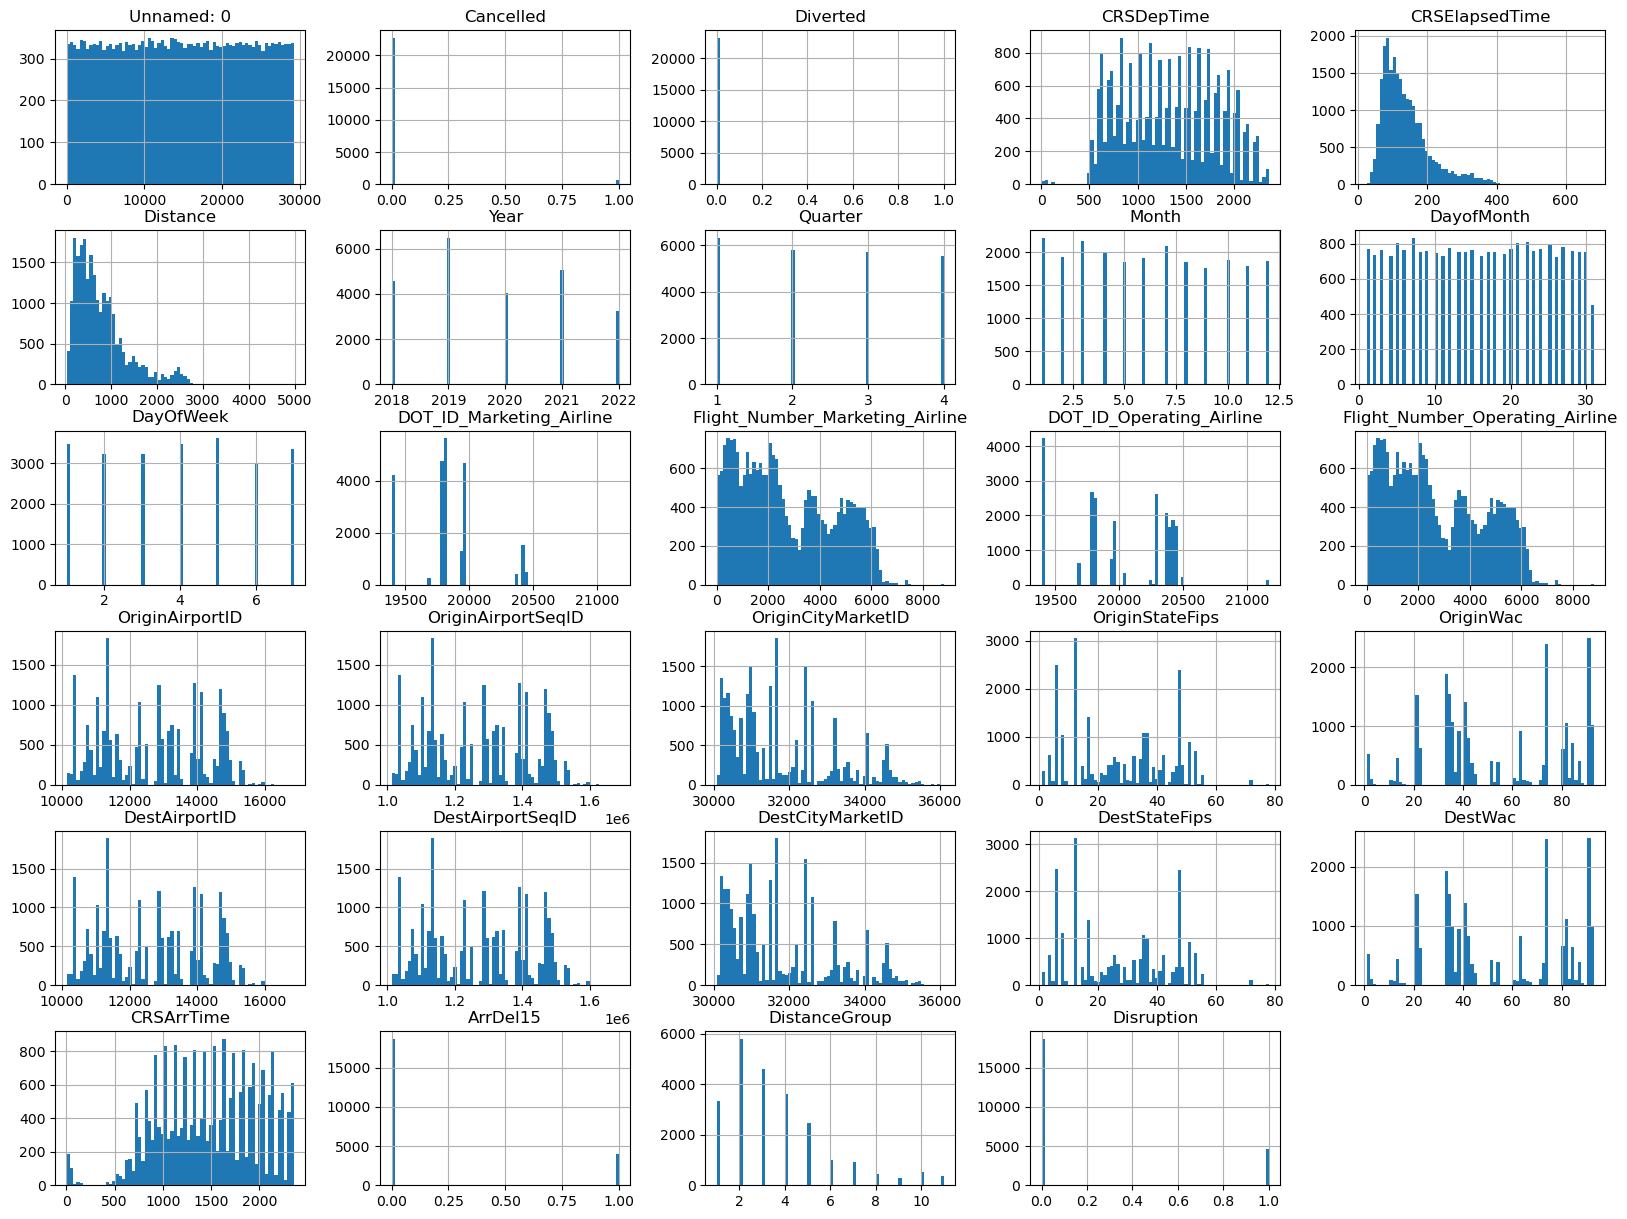

In [9]:
# Have a quick look at the data
%matplotlib inline
flights_train.hist(bins=70, figsize=(20,15))
plt.show()

Result/Considerations:

* Year: Overall relatively evenly distributed, peak in 2019. We are likely to see the reduction from 2019 to 2020 due to the COVID19 pandemic.
* Month: Overall relatively evenly distributed, peak month in January, March, July.
* DayofMonth: Overall relatively evenly distributed. 31st only half of the average (because the last day of a month only occurs in half of the month per year).
* DistanceGroup: Tail heavy: Peak in category 2, then long tail. We could try to create more balanced groups like short, medium, long distance. We could also consider dropping this feature and instead using the Distance feature for a more accurate splitting.


### 5.2 Categorical Features

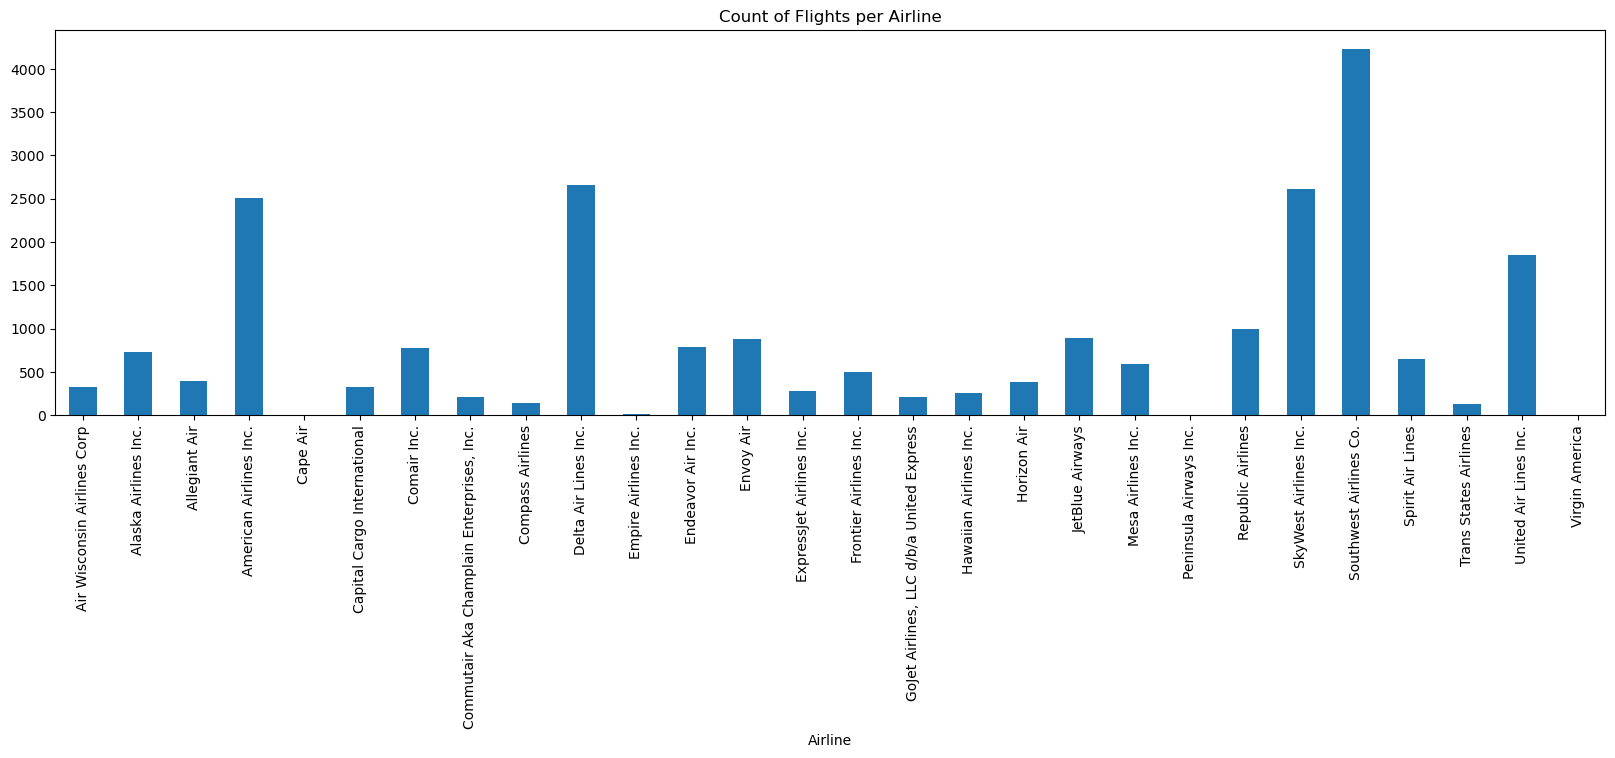

In [10]:
# Airline
# Categories not balanced - some airlines operated more flights than others.
# We could group the airlines into large, medium, and small airline, by the number of flights operated.

# Count the number of flights per airline
flight_count_airline = flights_train.groupby(["Airline"]).size()

# Plot bar chart
flight_count_airline.plot(kind="bar", figsize=(20,5))
plt.title("Count of Flights per Airline")
plt.show()

Text(0.5, 1.0, 'Count of flights per Origin State')

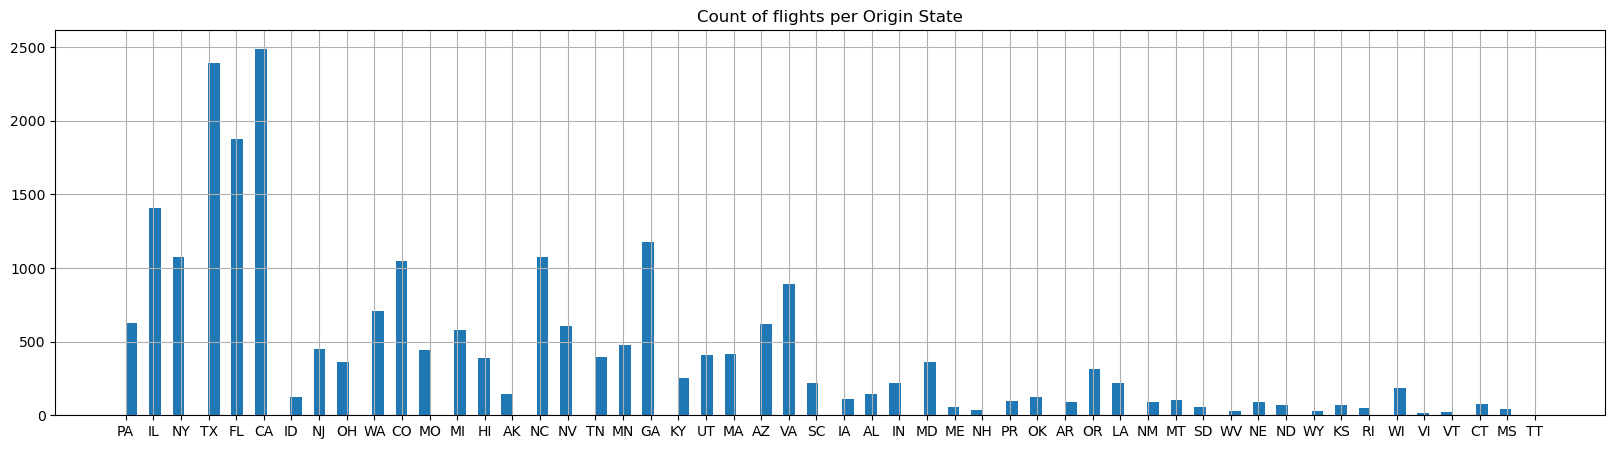

In [11]:
# OriginState
# Origin not balanced - some origin states are more often frequented than others
flights_train["OriginState"].hist(bins=120, figsize=(20,5))

plt.title("Count of flights per Origin State")

Text(0.5, 1.0, 'Count of flights per Destination State')

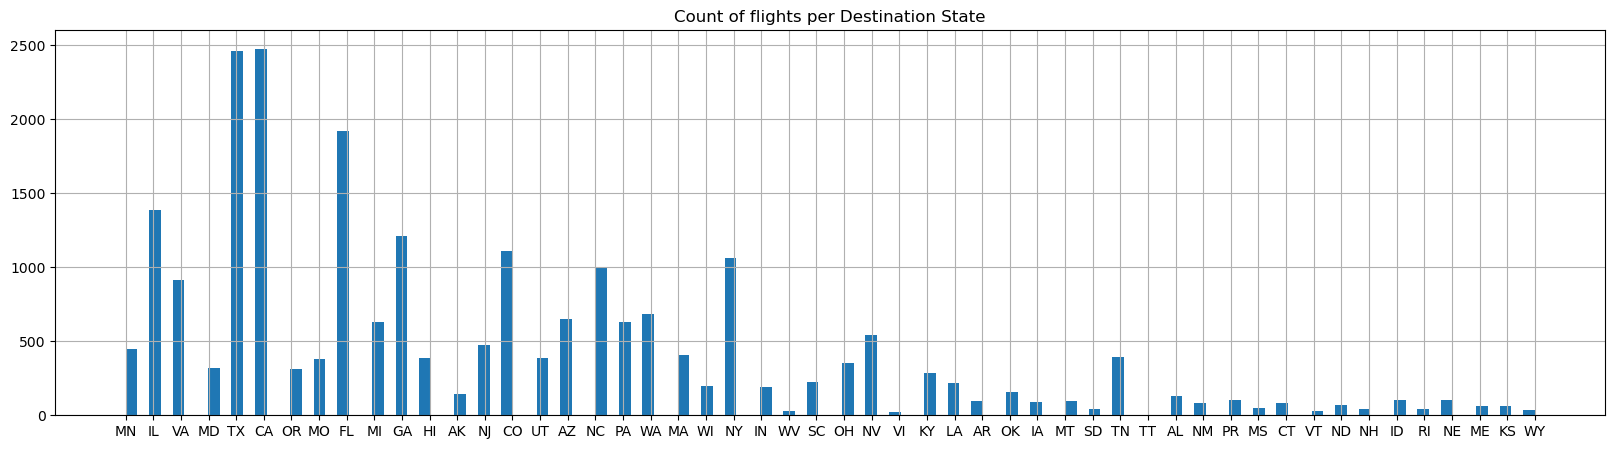

In [12]:
# DestState
# as for OriginState: categories not balanced, some destinations are more frequent than others
flights_train["DestState"].hist(bins=120, figsize=(20,5))

plt.title("Count of flights per Destination State")

Text(0.5, 1.0, 'Count of flights per Departure Time Block')

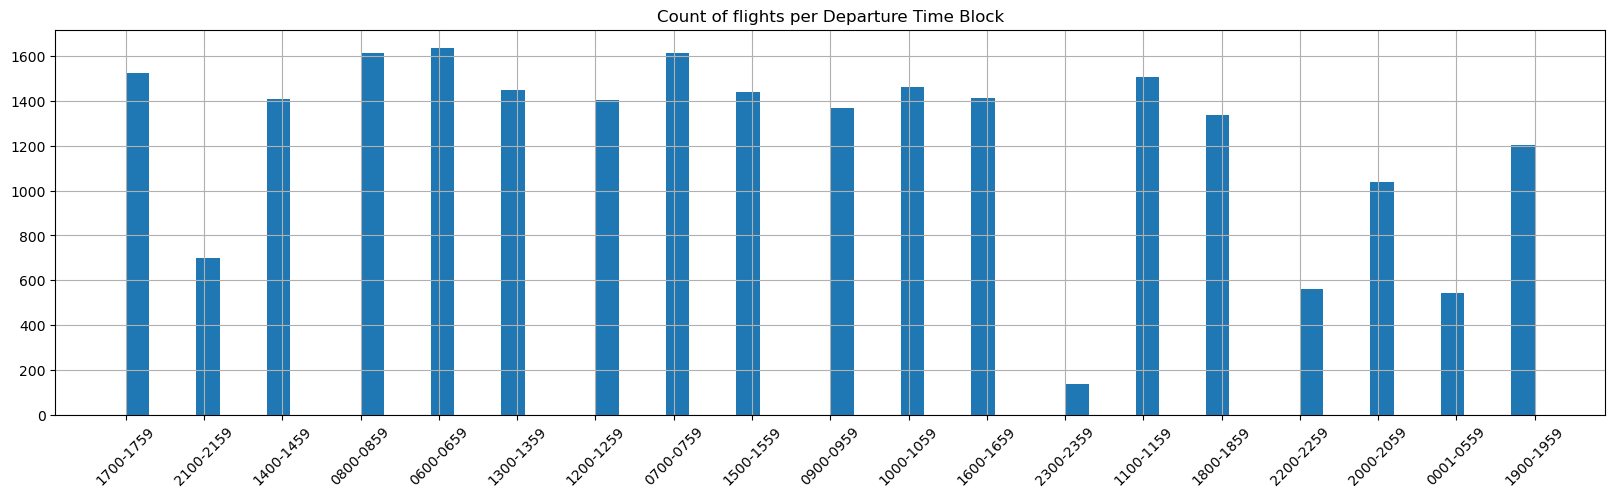

In [13]:
# Categories are not very balanced; 
# 19 distinct categories. We could consider splitting time slots into before noon and after noon to reduce dimensions.
flights_train["DepTimeBlk"].hist(bins=60, figsize=(20,5));
plt.xticks(rotation=45)
plt.title("Count of flights per Departure Time Block")

### Order

<Axes: ylabel='Disruption'>

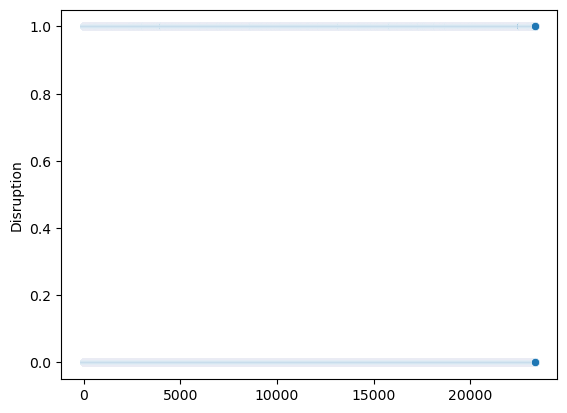

In [14]:
# There is no obvious pattern compared to the order of the data for Disruption
sns.scatterplot(x=list(range(len(flights_train))), y=flights_train["Disruption"])

<Axes: xlabel='Year'>

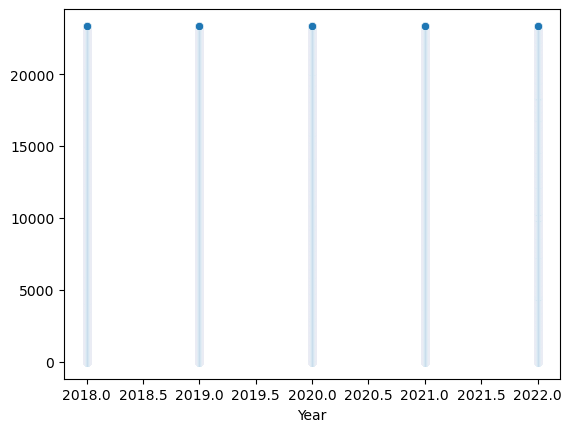

In [15]:
# There is no obvious pattern compared to the order of the data for Year
# checked also for Month, DayofMonth
sns.scatterplot(y=list(range(len(flights_train))), x=flights_train["Year"])

### Relationship with Response

<Axes: xlabel='Distance', ylabel='Disruption'>

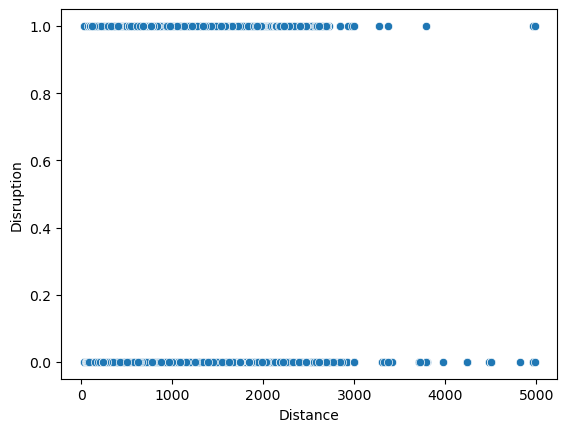

In [16]:
# Distance
sns.scatterplot(x=flights_train["Distance"], y=flights_train["Disruption"])

# flights between 4000 and 5000 miles distance seem not to be disrupted

<Axes: xlabel='CRSDepTime', ylabel='Disruption'>

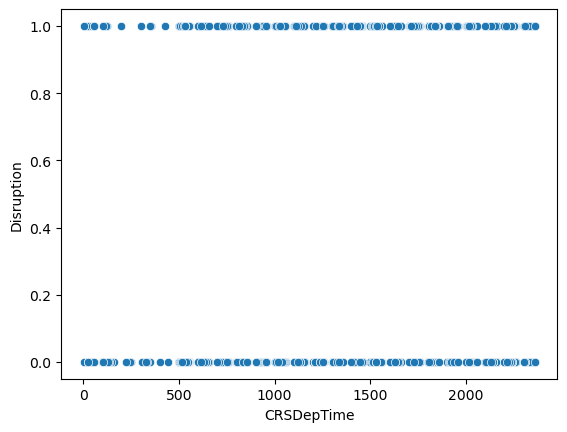

In [17]:
# CRSDepTime
sns.scatterplot(x=flights_train["CRSDepTime"], y=flights_train["Disruption"])

<Axes: xlabel='CRSArrTime', ylabel='Disruption'>

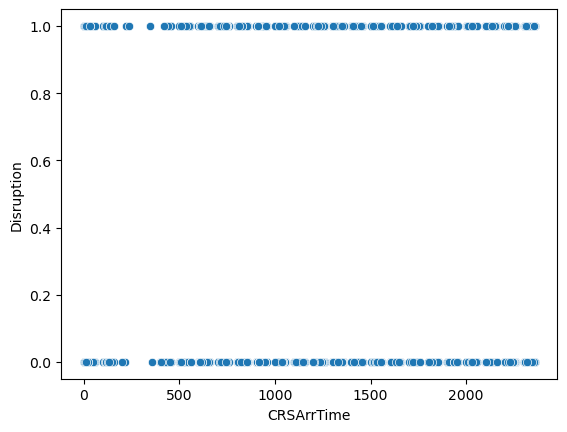

In [18]:
# CRSArrTime
sns.scatterplot(x=flights_train["CRSArrTime"], y=flights_train["Disruption"])

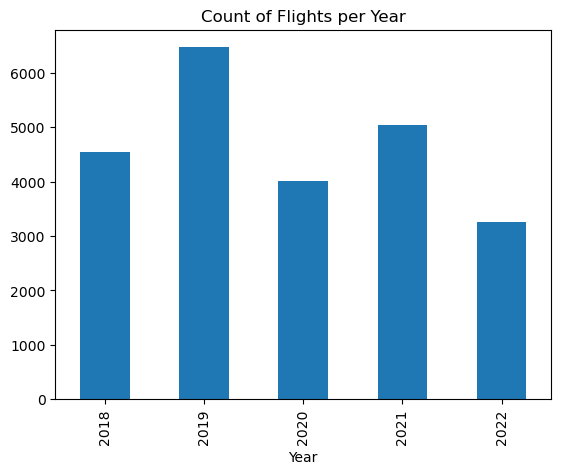

In [19]:
# Count the number of flights per year
flight_count_airline = flights_train.groupby(["Year"]).size()

# Plot bar chart
flight_count_airline.plot(kind="bar")
plt.title("Count of Flights per Year")
plt.show()
# We have a different total number of flights per year. 

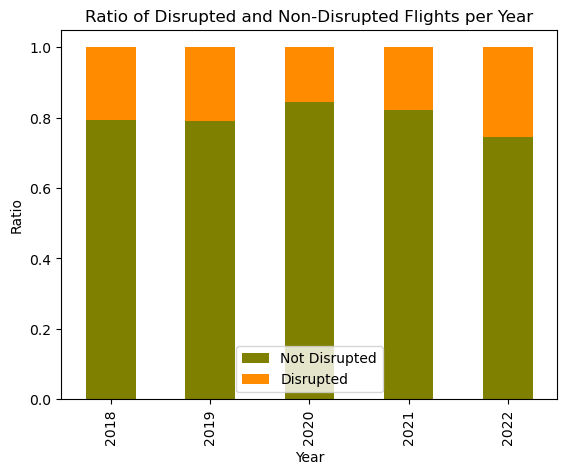

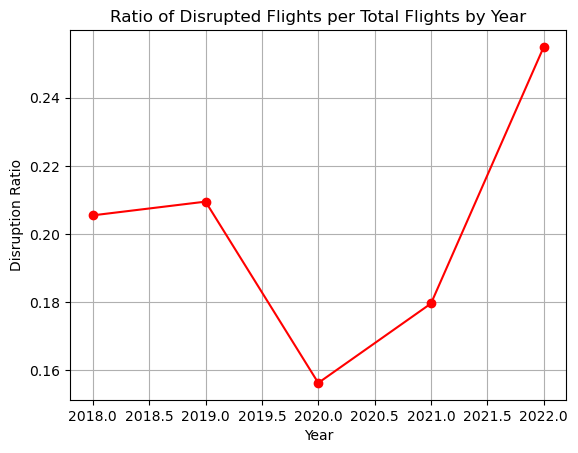

In [20]:
# Count number of disruptions for each year
disruptions = flights_train.groupby("Year")["Disruption"].value_counts().unstack()

# Calculate total number of flights for each year
total_flights = flights_train["Year"].value_counts()

# Calculate ratio of disruptions per count of total flights per year
disruption_ratio = disruptions.divide(total_flights, axis=0)

# Define colors for the stacked bars
colors = ['olive', 'darkorange']

# Plot the bar chart
disruption_ratio.plot(kind="bar", stacked=True, color=colors)
plt.title("Ratio of Disrupted and Non-Disrupted Flights per Year")
plt.legend(labels=['Not Disrupted', 'Disrupted'])
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.show()

# Calculate the ratio of disruptions per count of total flights per year
disruption_ratio = disruptions[1].divide(total_flights, axis=0)

# Plot the line graph for disrupted ratio
disruption_ratio.plot(kind="line", marker="o", color="red")
plt.title("Ratio of Disrupted Flights per Total Flights by Year")
plt.xlabel("Year")
plt.ylabel("Disruption Ratio")
plt.grid(True)
plt.show()

# We can see that despite the COVID19 pandemic, there are less disruptions in 2020 and 2021 compared to the other years. 
# However, we can see that 2022 (post pandemic) has more disruptions than pre pandemic years.

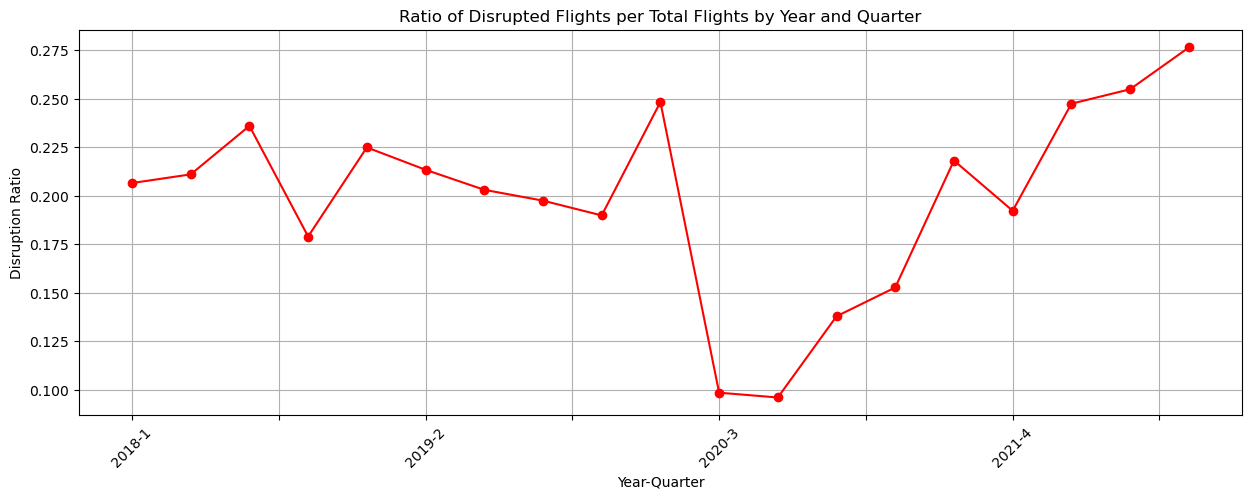

In [21]:
# Combine Year and Quarter into a single column
flights_train["Year_Quarter"] = flights_train["Year"].astype(str) + "-" + flights_train["Quarter"].astype(str)

# Count the number of disruptions for each year and quarter
disruptions = flights_train.groupby(["Year_Quarter", "Disruption"]).size().unstack()

# Calculate the total number of flights for each year and quarter
total_flights = flights_train["Year_Quarter"].value_counts()

# Calculate the ratio of disruptions per count of total flights per year and quarter
disruption_ratio = disruptions[1].divide(total_flights, axis=0)

# Plot the line graph for disrupted ratio
disruption_ratio.plot(figsize=(15, 5), kind="line", marker="o", color="r")
plt.title("Ratio of Disrupted Flights per Total Flights by Year and Quarter")
plt.xlabel("Year-Quarter")
plt.ylabel("Disruption Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# A more granular exploration per year and quarter reveals that there were significantly more disruptions in the second 2020 quarter - during the first pandemic phase,
# followed by a significant drop of the disruption ratio in the third 2020 quarter. After that, the disruption rate rises and exceeds the pre pandemic level.

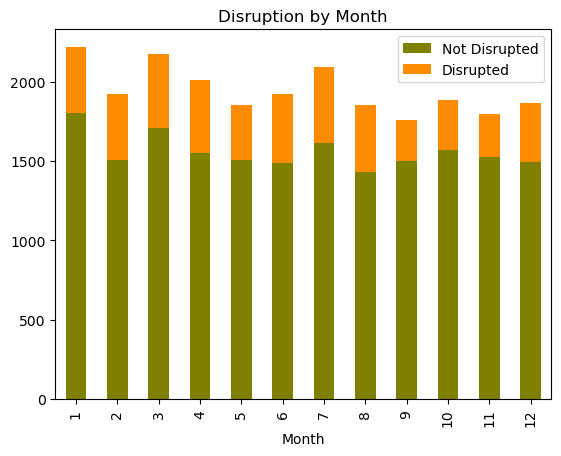

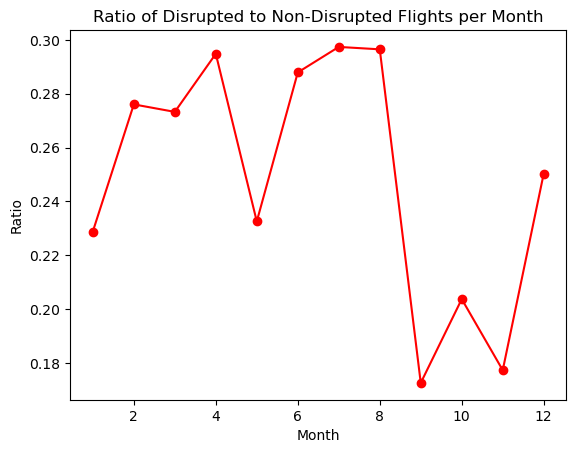

In [22]:
# Count the number of disruptions for each month
disruptions = flights_train.groupby(["Month", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title('Disruption by Month')
plt.legend(labels=['Not Disrupted', 'Disrupted'])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="line", marker="o", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per Month')
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.show()

# We see differences between months. Some month have a higher disruption rate than others.

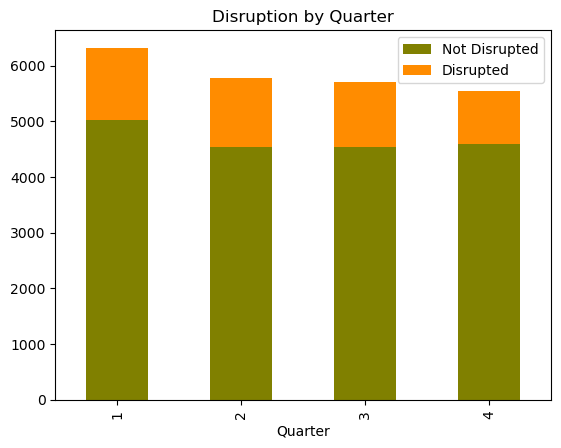

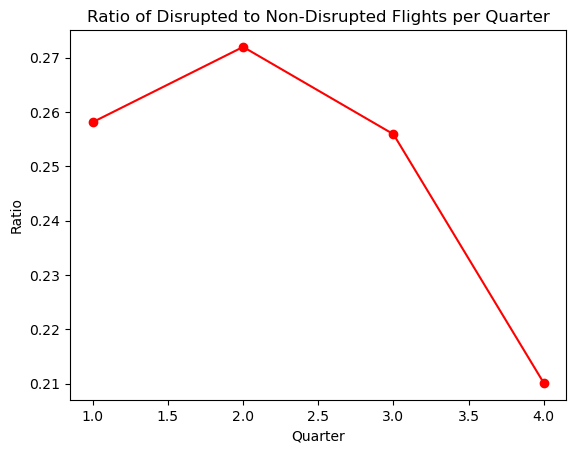

In [23]:
# Count the number of disruptions for each quarter
disruptions = flights_train.groupby(["Quarter", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by Quarter")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per quarter
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="line", marker="o", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Ratio')
plt.show()

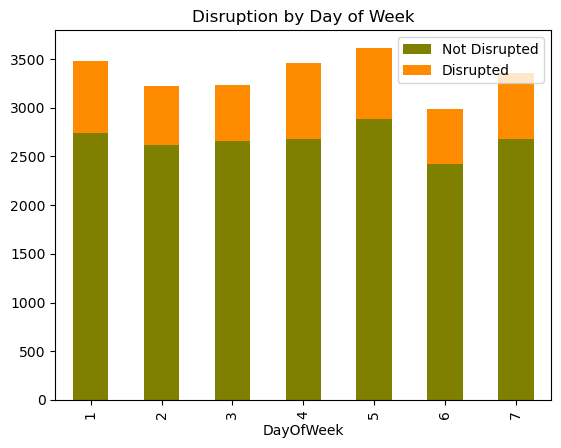

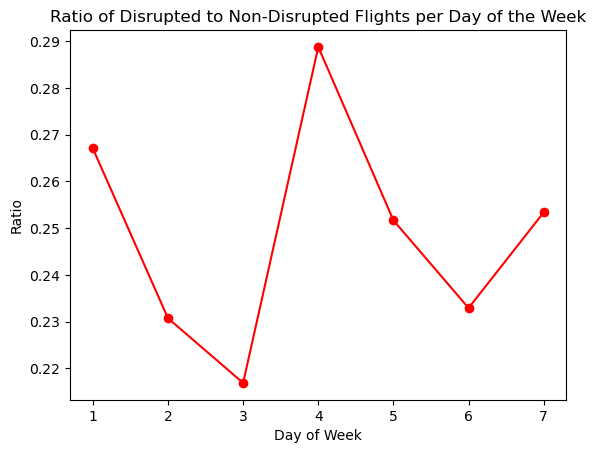

In [24]:
# Count the number of disruptions for each day of a week
disruptions = flights_train.groupby(["DayOfWeek", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by Day of Week")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per day of the week
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="line", marker="o", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Ratio')
plt.show()

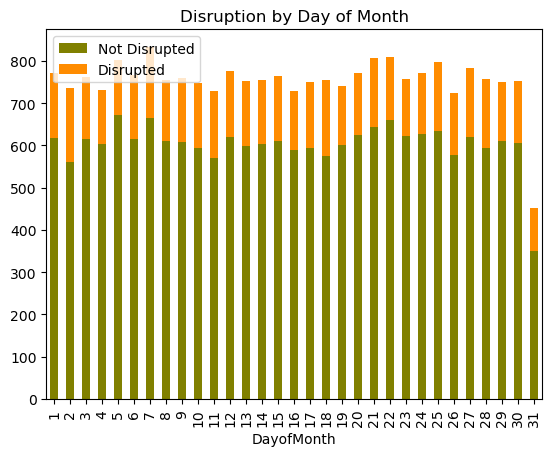

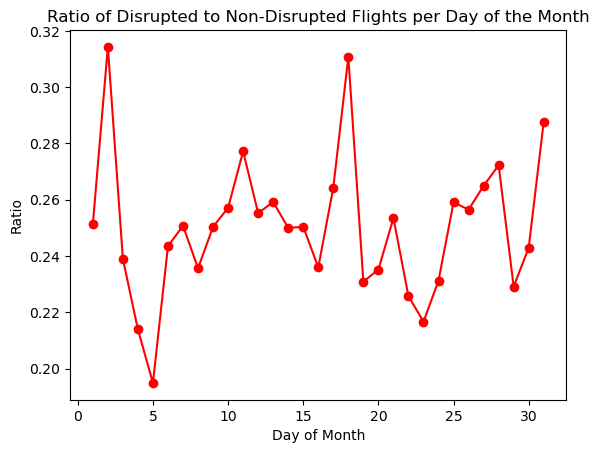

In [25]:
# Count the number of disruptions for each day of a month
disruptions = flights_train.groupby(["DayofMonth", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by Day of Month")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="line", marker="o", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per Day of the Month')
plt.xlabel('Day of Month')
plt.ylabel('Ratio')
plt.show()

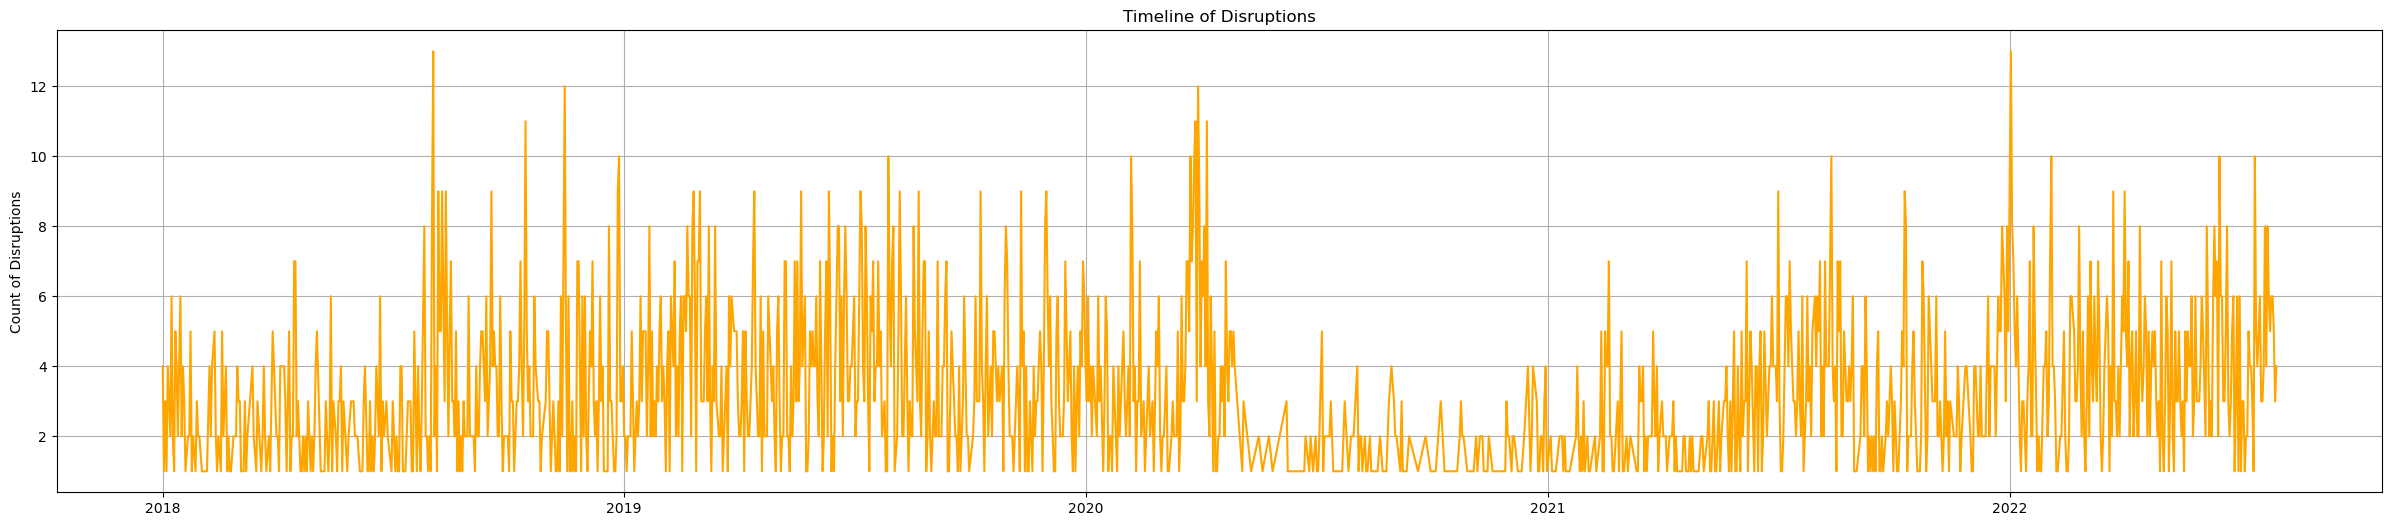

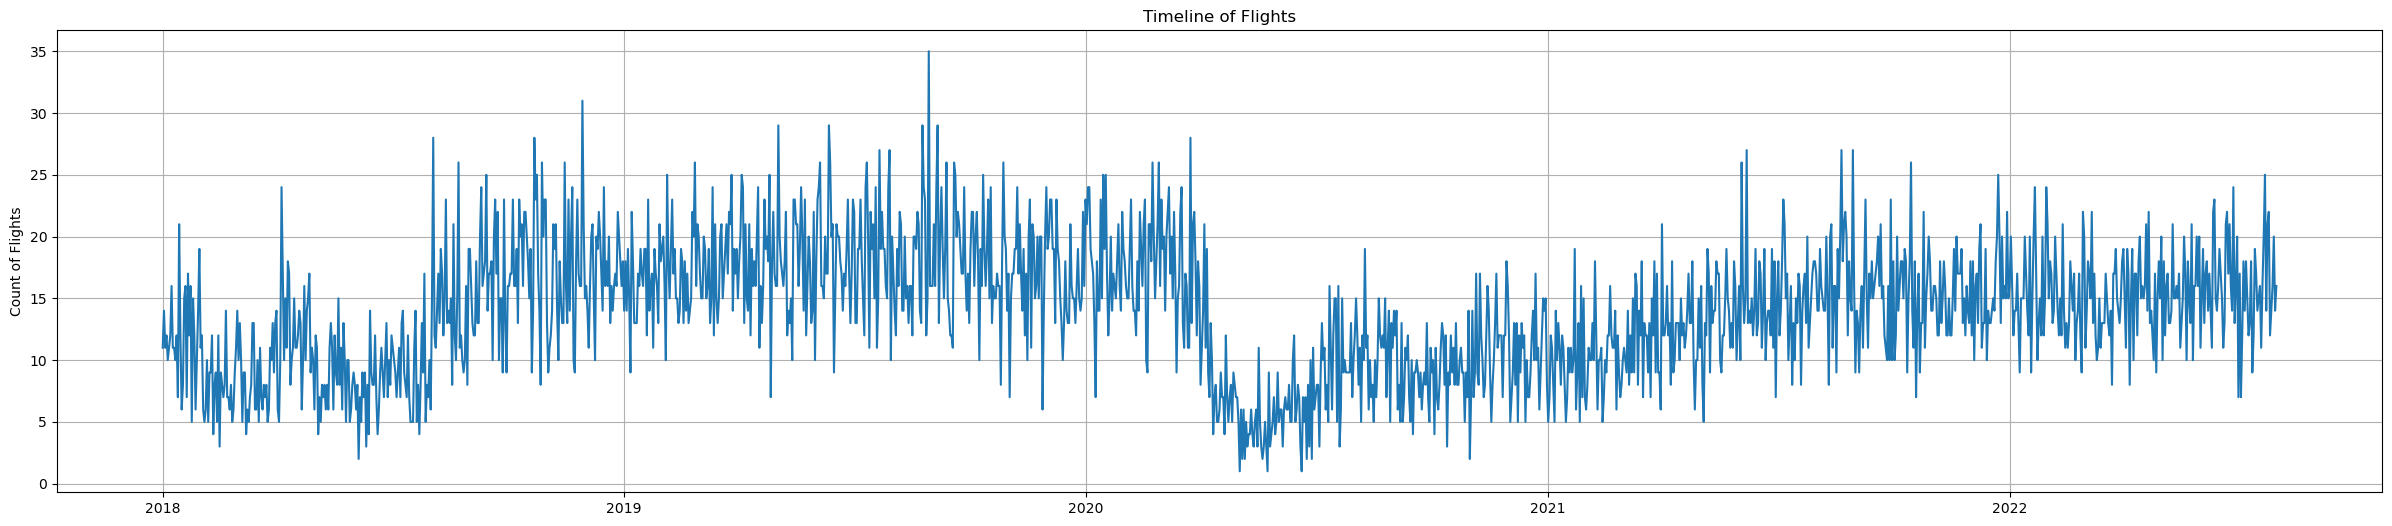

In [26]:
# Convert the column to datetime data type
flights_train["FlightDate"] = pd.to_datetime(flights_train["FlightDate"])

# Filter the DataFrame to include only rows where 'Disruption' is equal to 1
disruptions = flights_train[flights_train["Disruption"] == 1]

# Group by the date column and count the number of disruptions for each date
disruptions_count = disruptions.groupby("FlightDate").size()

# Plot the timeline
plt.figure(figsize=(30, 6))
plt.plot(disruptions_count.index, disruptions_count.values, color="orange")
plt.ylabel("Count of Disruptions")
plt.title("Timeline of Disruptions")
plt.grid(True)
plt.show()


# Convert the column to datetime data type
flights_train["FlightDate"] = pd.to_datetime(flights_train["FlightDate"])

# Group by the date column and count the number of flights for each date
flights_count = flights_train.groupby("FlightDate").size()

# Plot the timeline
plt.figure(figsize=(30, 6))
plt.plot(flights_count.index, flights_count.values)
plt.ylabel("Count of Flights")
plt.title("Timeline of Flights")
plt.grid(True)
plt.show()

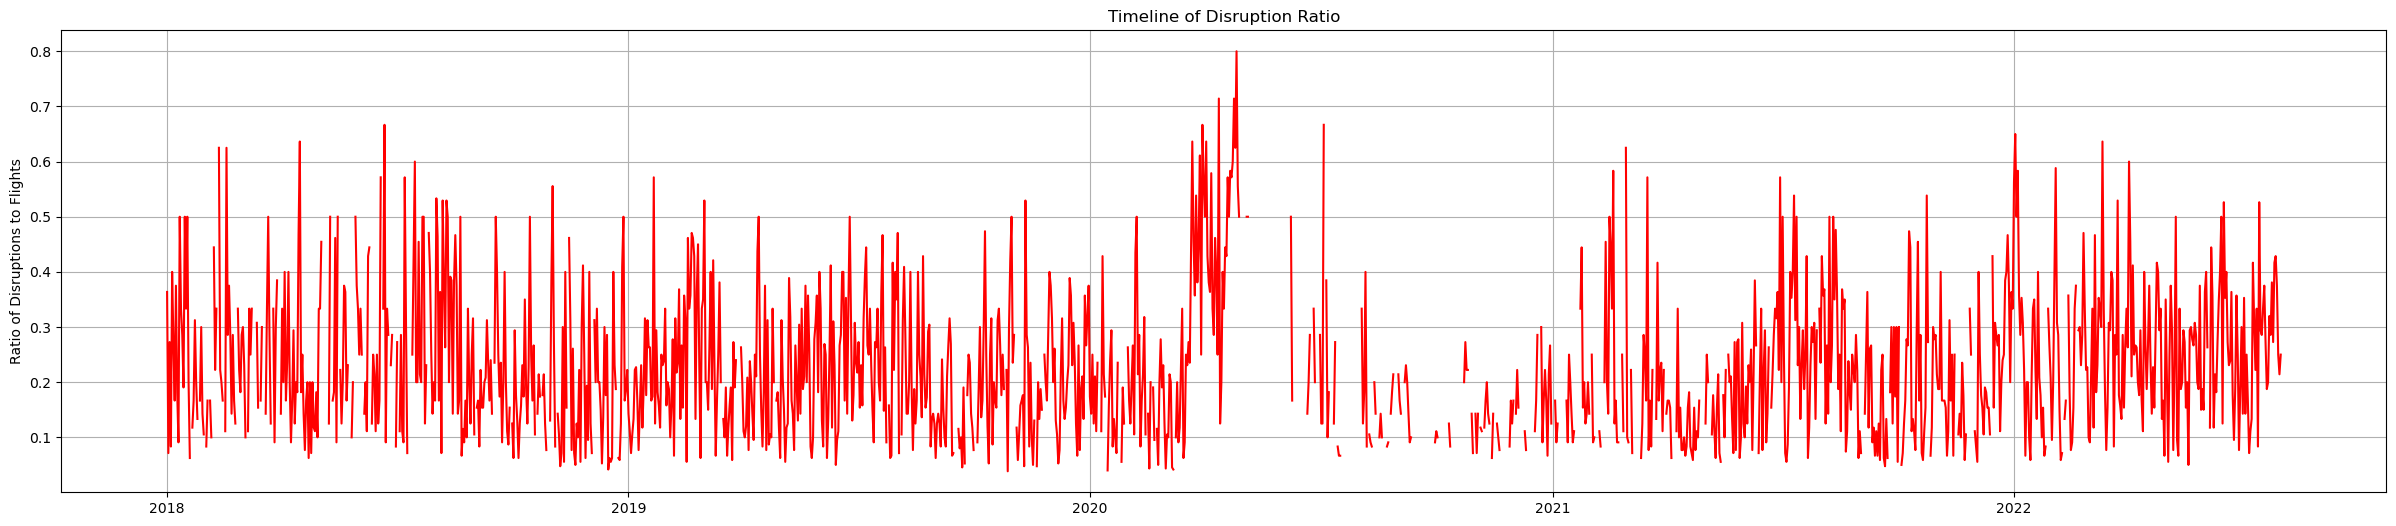

In [27]:
# Calculate the ratio of disruptions to flights for each date
ratio = disruptions_count.div(flights_count)

# Plot the timeline
plt.figure(figsize=(30, 6))
plt.plot(ratio.index, ratio.values, color="red")
plt.ylabel("Ratio of Disruptions to Flights")
plt.title("Timeline of Disruption Ratio")
plt.grid(True)
plt.show()

#### Results of the Timeline Analysis:

We can see that there has been an accumulation of disruptions in the beginning of the second quarter of 2020. After that, disruptions dropped significantly, but so did the number of flights as well. The ratio of disruptions by flights shows missing data points from mid 2020 to the beginning of 2021.

We can see that the COVID19 pandemic introduces an abnormal pattern to the usual data trend. For predicting future flights, it would therefore be worth considering to drop rows that fall into this abnormal time period, such as 2020 quarter 2 and 3.

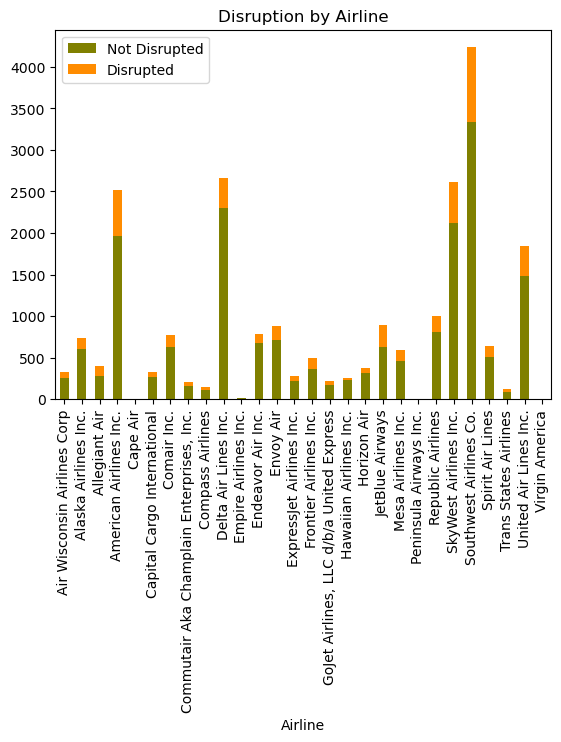

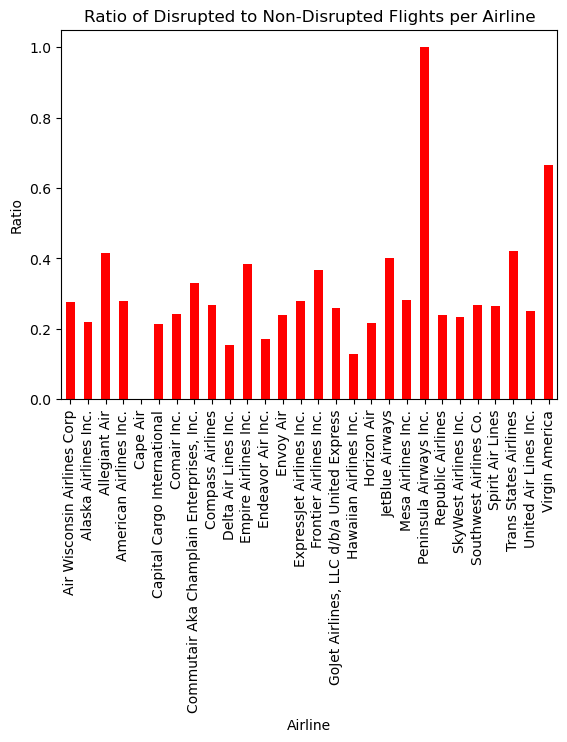

In [28]:
# Count the number of disruptions for each airline
disruptions = flights_train.groupby(["Airline", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by Airline")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="bar", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per Airline')
plt.xlabel('Airline')
plt.ylabel('Ratio')
plt.show()

# seems like Airline could be a weak indicator for disruptions - we see e.g. Delta has lower disruptions than American Airlines despite more flights in total

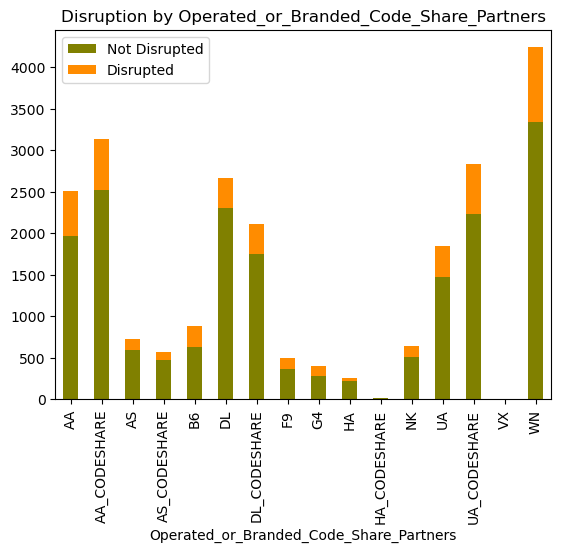

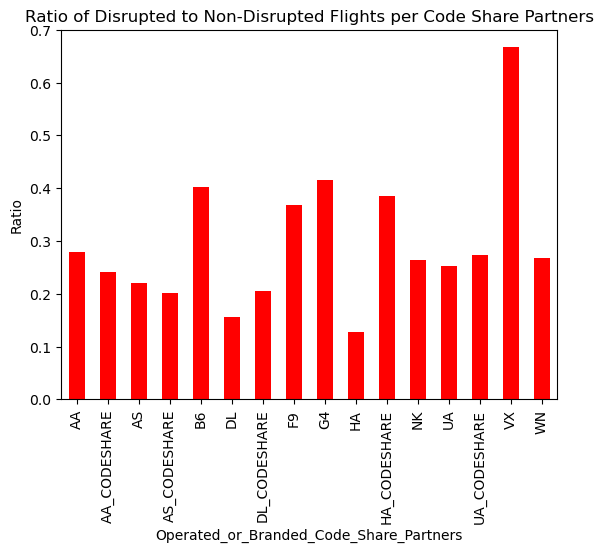

In [29]:
# Count the number of disruptions for code sharing flights
disruptions = flights_train.groupby(["Operated_or_Branded_Code_Share_Partners", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by Operated_or_Branded_Code_Share_Partners")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="bar", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per Code Share Partners')
plt.xlabel('Operated_or_Branded_Code_Share_Partners')
plt.ylabel('Ratio')
plt.show()

# There seem to be significant differences between code share categories. Some partners have much higher disruption ratios than others.

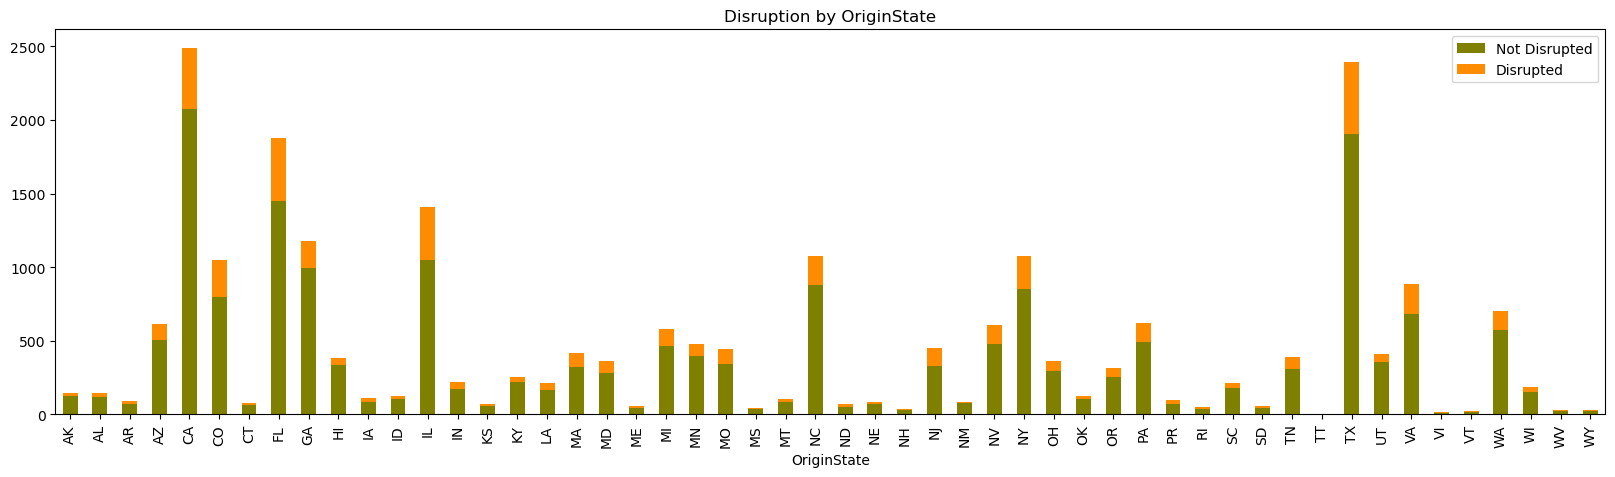

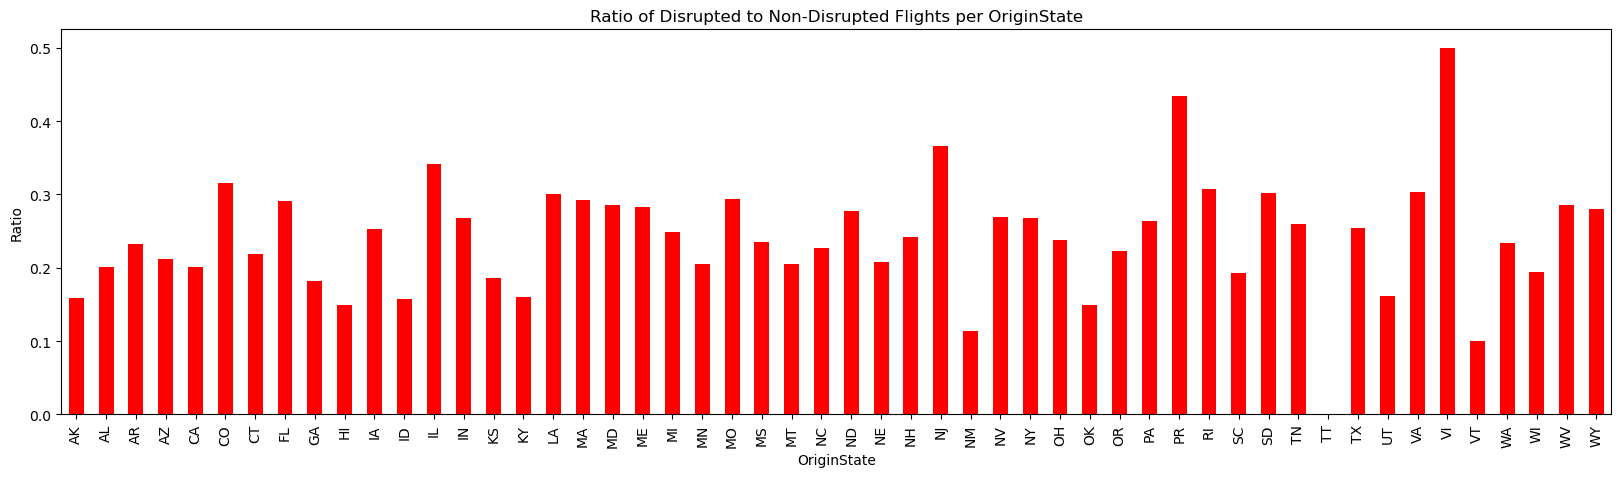

In [30]:
# Count the number of disruptions for each airline
disruptions = flights_train.groupby(["OriginState", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(figsize=(20,5), kind="bar", stacked=True, color=colors)
plt.title("Disruption by OriginState")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(figsize=(20,5), kind="bar", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per OriginState')
plt.xlabel('OriginState')
plt.ylabel('Ratio')
plt.show()

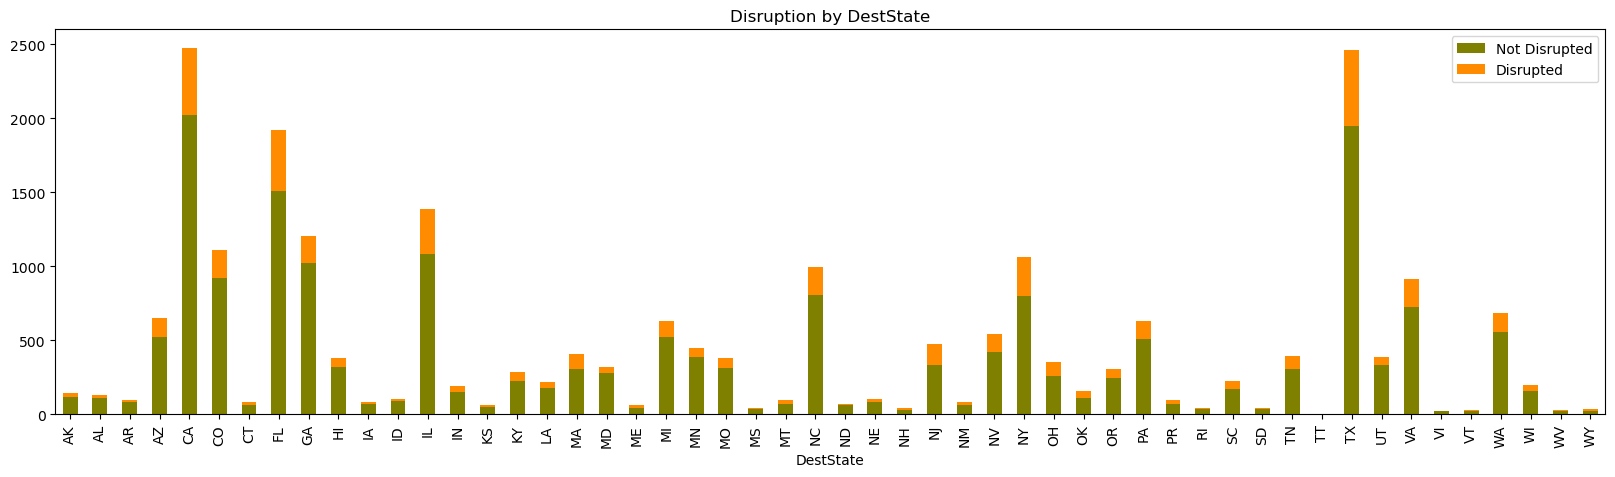

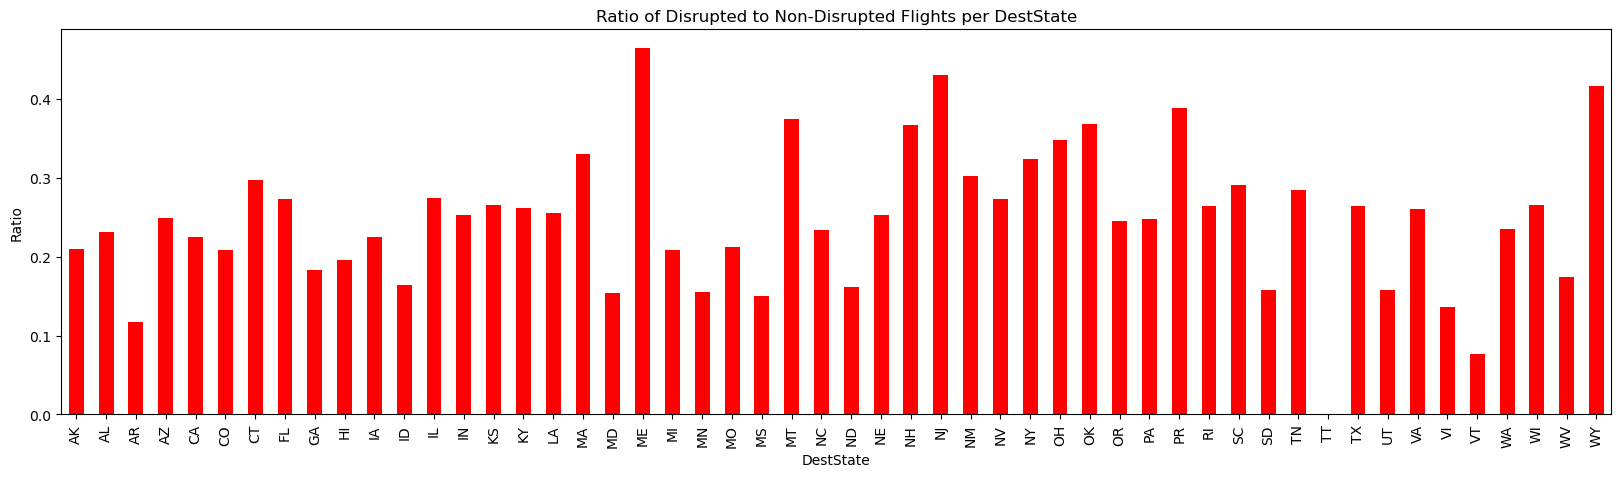

In [31]:
# Count the number of disruptions for each destination
disruptions = flights_train.groupby(["DestState", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(figsize=(20,5), kind="bar", stacked=True, color=colors)
plt.title("Disruption by DestState")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(figsize=(20,5), kind="bar", color='red')
plt.title('Ratio of Disrupted to Non-Disrupted Flights per DestState')
plt.xlabel('DestState')
plt.ylabel('Ratio')
plt.show()

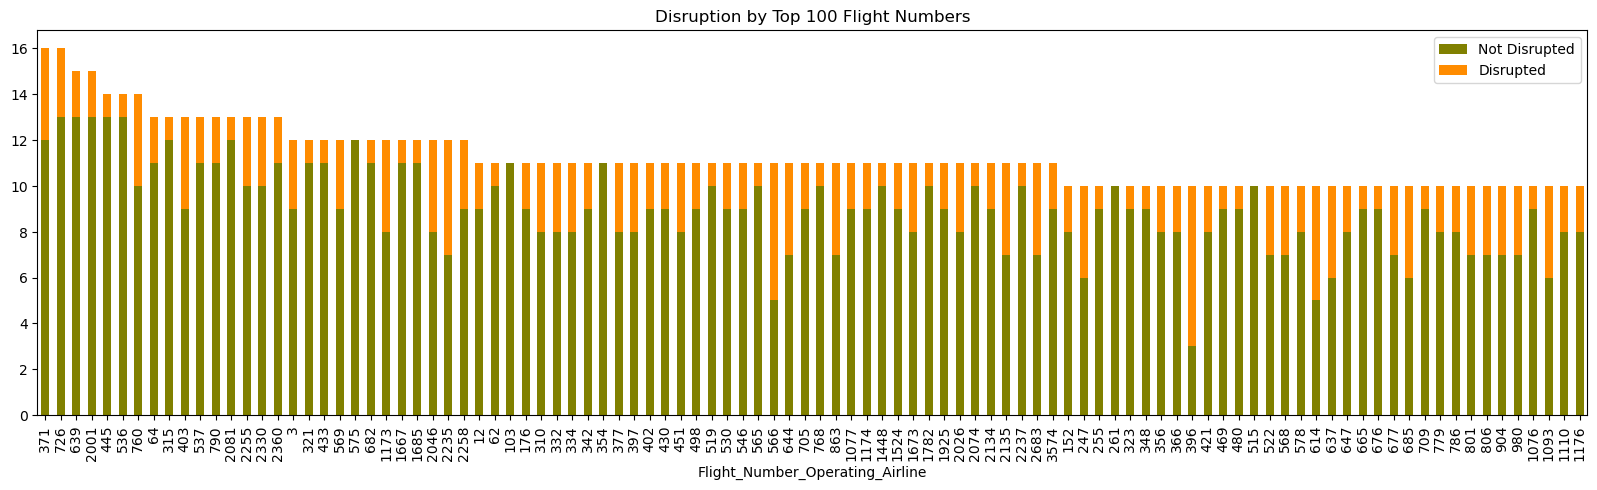

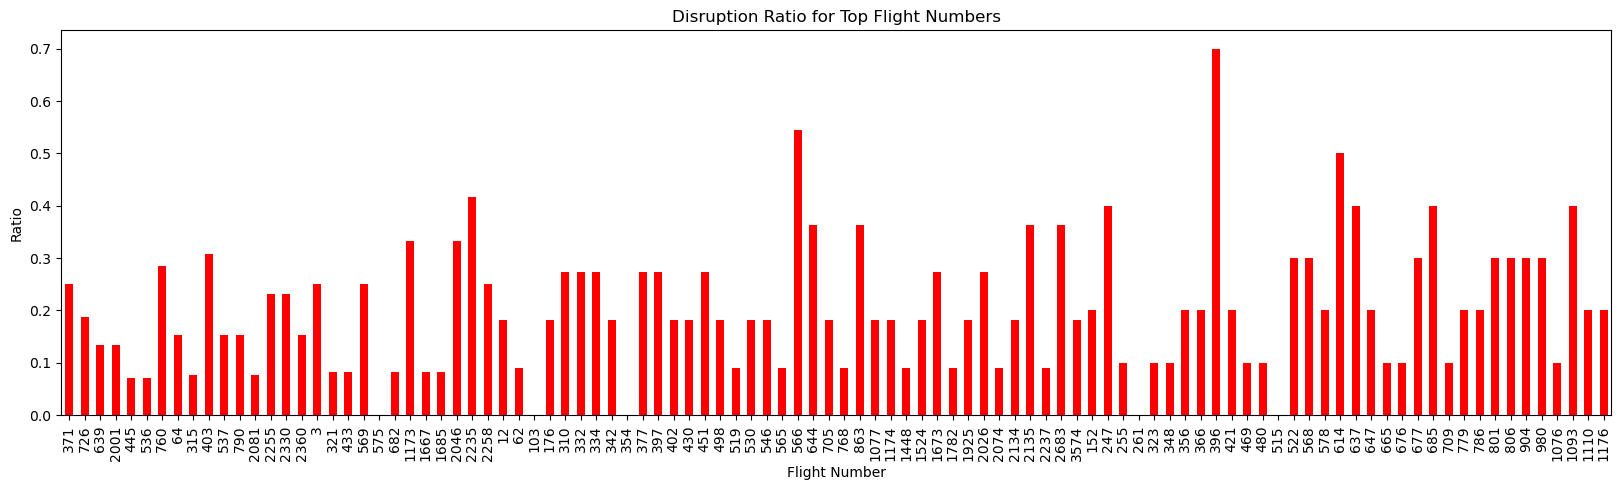

In [32]:
# Count the number of disruptions for each flight number
disruptions = flights_train.groupby(["Flight_Number_Operating_Airline", "Disruption"]).size().unstack()

# Select top N categories based on frequency counts
top_n = 100
top_disruptions = disruptions.sum(axis=1).nlargest(top_n).index
disruptions_top_n = disruptions.loc[top_disruptions]

# Plot the grouped bar chart
disruptions_top_n.plot(figsize=(20,5), kind="bar", stacked=True, color=colors)
plt.title("Disruption by Top 100 Flight Numbers")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Total number of flights for each flight number
total_flights = disruptions_top_n.sum(axis=1)

# Ratio of disrupted to total flights for each flight number
disruption_ratio = disruptions_top_n[1] / total_flights

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(figsize=(20,5), kind="bar", color='red')
plt.title('Disruption Ratio for Top Flight Numbers')
plt.xlabel('Flight Number')
plt.ylabel('Ratio')
plt.show()

# flight number may be a predictor for disruption
# there seem to be differences between flight numbers: Some were never disrupted, some very often.

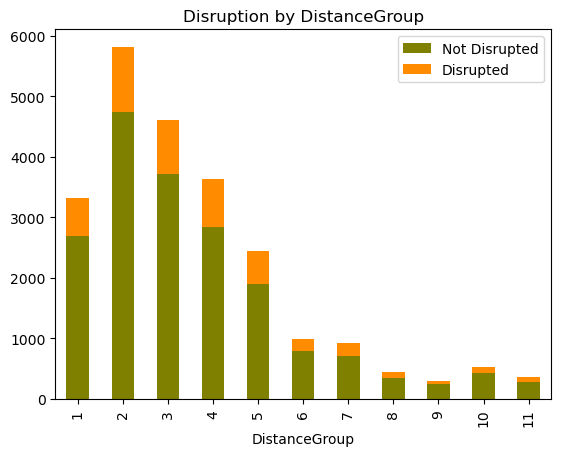

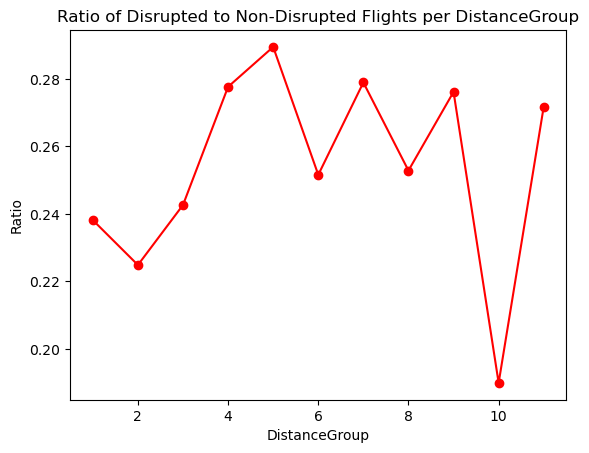

In [33]:
# Count the number of disruptions for each distance group
disruptions = flights_train.groupby(["DistanceGroup", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by DistanceGroup")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="line", color='red', marker="o")
plt.title('Ratio of Disrupted to Non-Disrupted Flights per DistanceGroup')
plt.xlabel('DistanceGroup')
plt.ylabel('Ratio')
plt.show()

# There are some differences, the disruption rate is between 0.2 and 0.3 across all distances. 
# There is no clear trend, e.g. that long distance flights are less disrupted than short distance flights. 
# As there is no clear pattern visible, I consider the distance in general not as a good predictor for disruptions.

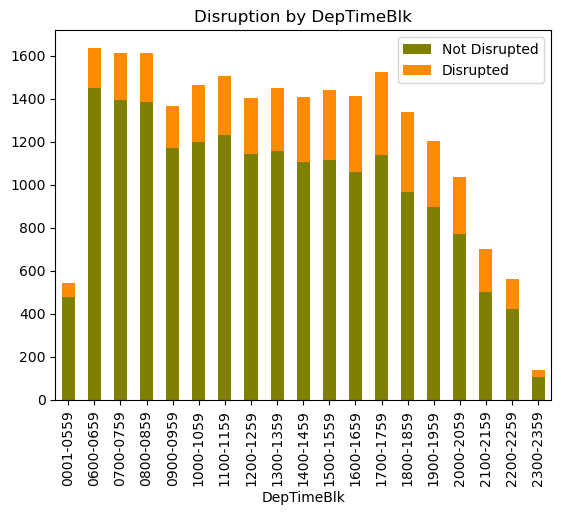

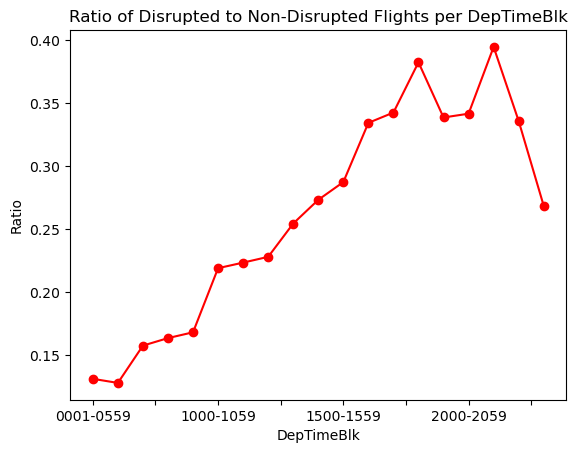

In [34]:
# Count the number of disruptions for each departure slot
disruptions = flights_train.groupby(["DepTimeBlk", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by DepTimeBlk")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="line", color='red', marker="o")
plt.title('Ratio of Disrupted to Non-Disrupted Flights per DepTimeBlk')
plt.xlabel('DepTimeBlk')
plt.ylabel('Ratio')
plt.show()

# There are significant differences between departure time slots
# Afternoon flights seem to have an increased disruption ratio compared to flights departing in the morning or late evening/night.

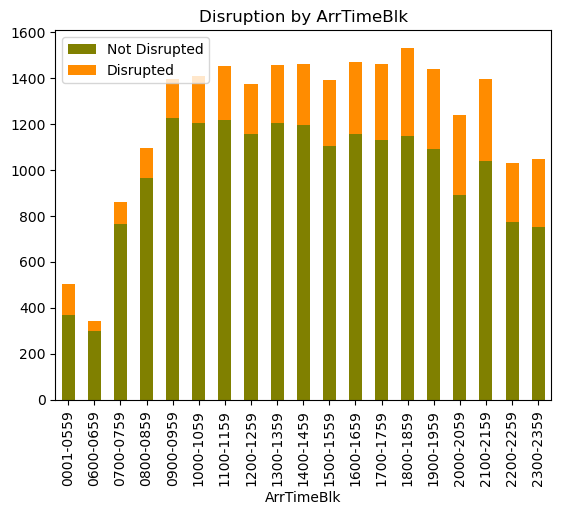

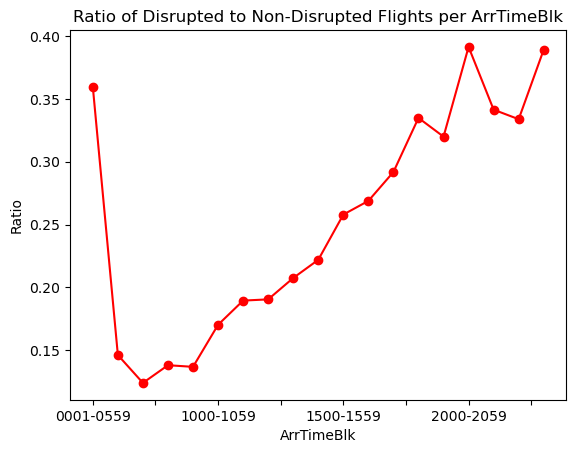

In [35]:
# Count the number of disruptions for each arrival slot
disruptions = flights_train.groupby(["ArrTimeBlk", "Disruption"]).size().unstack()

# Plot the grouped bar chart
disruptions.plot(kind="bar", stacked=True, color=colors)
plt.title("Disruption by ArrTimeBlk")
plt.legend(labels=["Not Disrupted", "Disrupted"])
plt.show()

# Calculate the ratio of disrupted to non-disrupted flights per month
disruption_ratio = disruptions[1] / disruptions[0]

# Plot the ratio as a stacked bar chart
disruption_ratio.plot(kind="line", color='red', marker="o")
plt.title('Ratio of Disrupted to Non-Disrupted Flights per ArrTimeBlk')
plt.xlabel('ArrTimeBlk')
plt.ylabel('Ratio')
plt.show()

# We see that flights departing directly after midnight are often disrupted.
# We see that flights before noon are less likely to be disrupted, with a rising trend during the day and highest ratio of disruptions with flights arriving in the evening/at night.

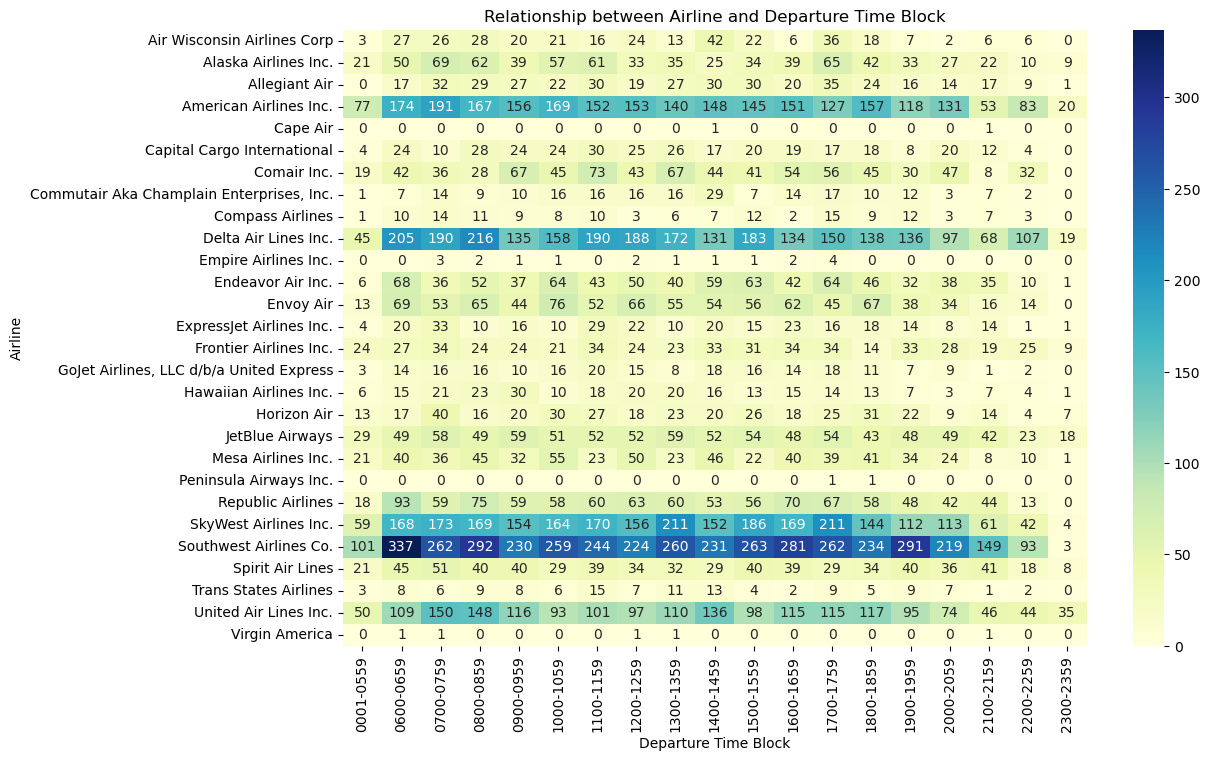

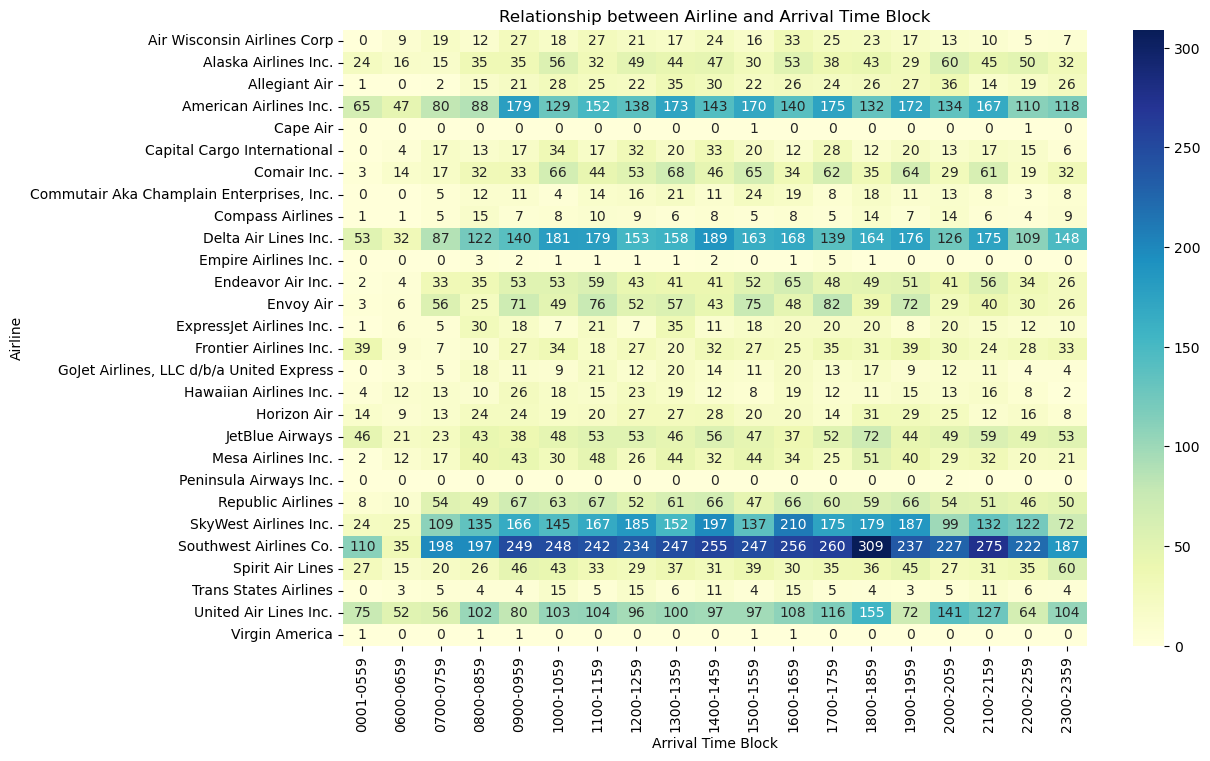

In [36]:
# Relationship between features
cross_tab = pd.crosstab(flights_train["Airline"], flights_train["DepTimeBlk"])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Relationship between Airline and Departure Time Block")
plt.xlabel("Departure Time Block")
plt.ylabel("Airline")
plt.show()

# Relationship between features
cross_tab = pd.crosstab(flights_train["Airline"], flights_train["ArrTimeBlk"])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Relationship between Airline and Arrival Time Block")
plt.xlabel("Arrival Time Block")
plt.ylabel("Airline")
plt.show()

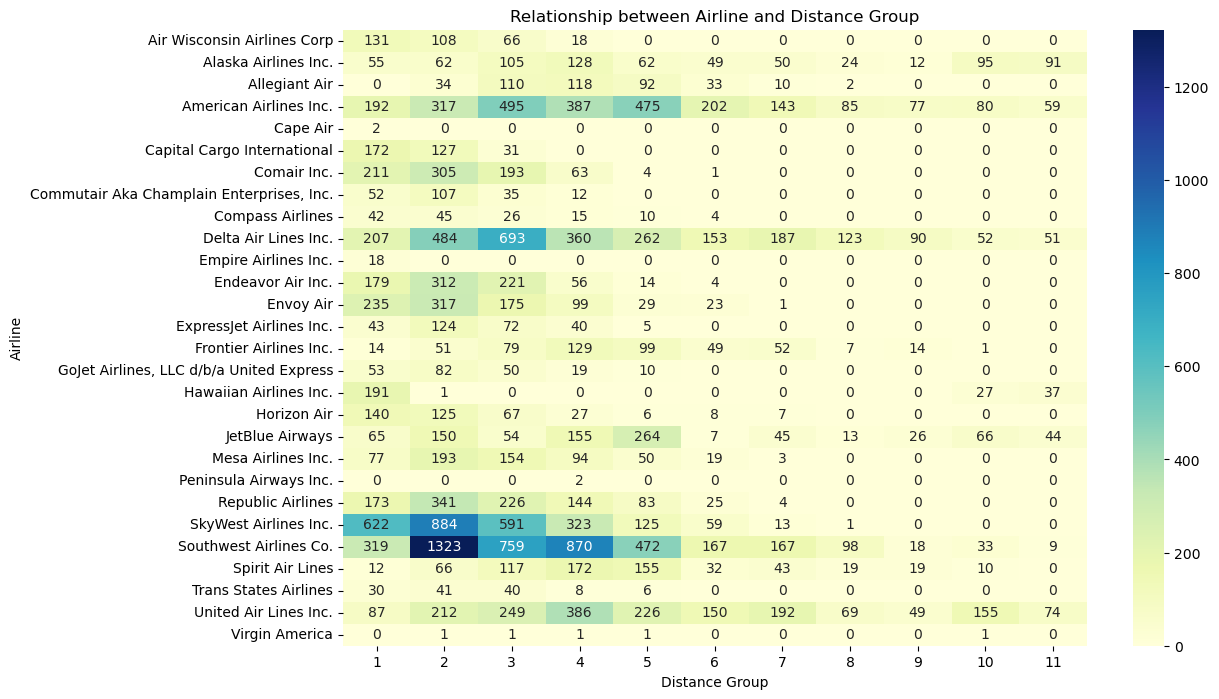

In [37]:
# Relationship between features
cross_tab = pd.crosstab(flights_train["Airline"], flights_train["DistanceGroup"])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Relationship between Airline and Distance Group")
plt.xlabel("Distance Group")
plt.ylabel("Airline")
plt.show()

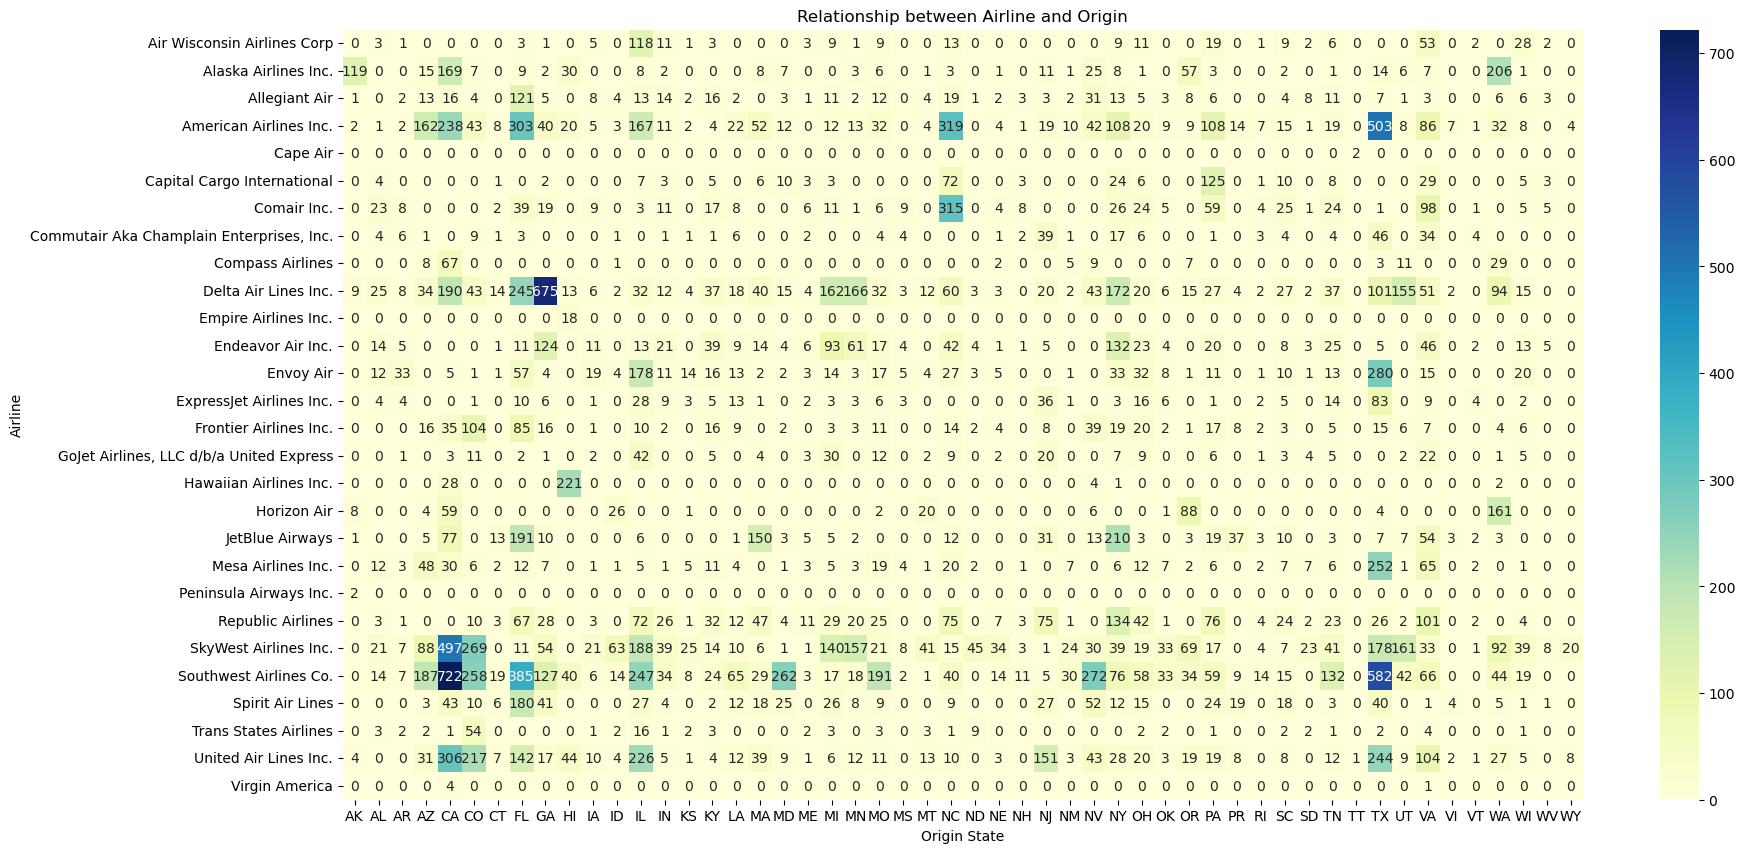

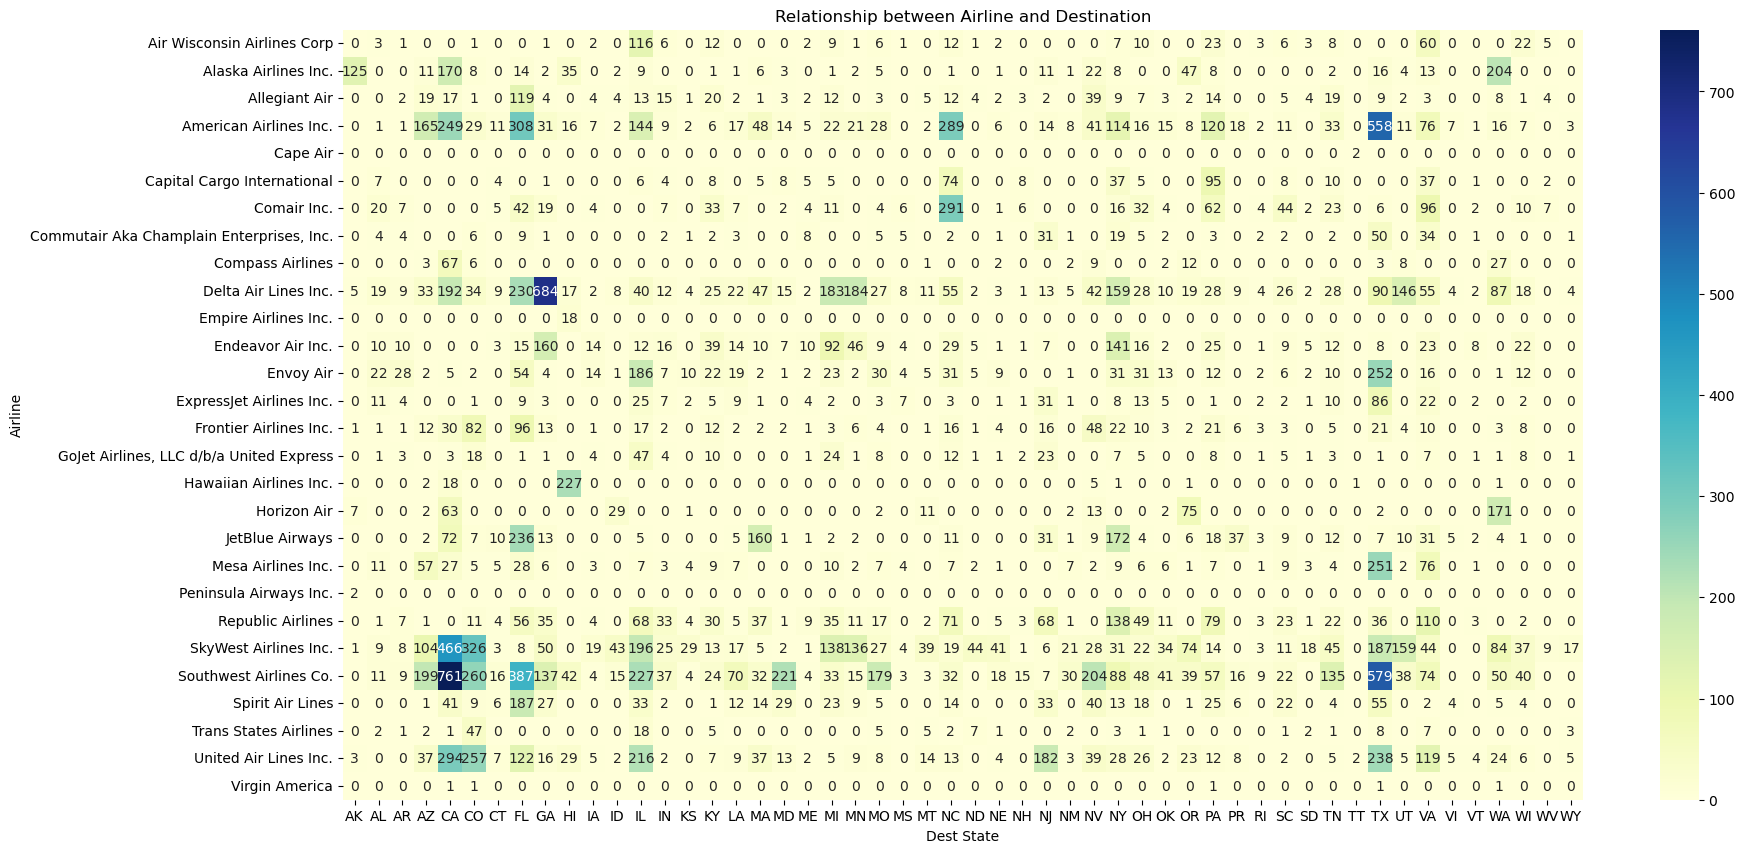

In [38]:
# Relationship between features

# Airline and OriginState
cross_tab = pd.crosstab(flights_train["Airline"], flights_train["OriginState"])

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(cross_tab, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Relationship between Airline and Origin")
plt.xlabel("Origin State")
plt.ylabel("Airline")
plt.show()

# Airline and DestState
cross_tab = pd.crosstab(flights_train["Airline"], flights_train["DestState"])

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(cross_tab, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Relationship between Airline and Destination")
plt.xlabel("Dest State")
plt.ylabel("Airline")
plt.show()

# Some Airlines seem to have a primary origin state - possibly, because airlines oftentimes have something like a "home" or base airport. 
# It is difficult to visually represent the relationship between airlines and airports as there are so many different airports across the US.
# However, using state instead gives us an indication that there are indeed relationships between airline and origin/destination of flights.
# We can also see that the heatmaps for Origin and Destination look similar - which supports the theory of airlines having home airports.
# Therefore, I think that including either of origin or destination state for the prediction is sufficient, no need to include both.

### Results of Data Exploration:

* Timeline Analysis reveals that there are difference between years, quarters, months, days of a month and days of a week. We also see that the COVID19 pandemic caused some extreme outliers (first a significant increase of disruptions, followed by a significant drop of disruptions). Therefore, flights during these phases have probably a limitation in being representative for disruption prediction of flights.

* We see a strong trend in arrival and departure time blocks. The later the departure/arrival, the higher the disruption ratio.

* There are significant differences in disruptions between airlines and origins/destinations. Furthermore, there is a relationship between some airlines and particular origins or destinations. This is reasonable given that many airlines have a home airport where most of their flights depart and arrive.

* There are also differences between distance groups. However, this can be the case because different airlines may serve specific distances (or particular flights falling into a specific distance group). Therefore, the differences in disruptions across distance groups can be due to the differences between airlines.

* There seem also to differences in disruptions across flight numbers. However, as there are more than 5000 different flight numbers in this dataset, it was infeasible to visualise all the whole dataset. I assume that the flight number is per se a good predictor for disruptions, as we could see from the top 100 flight numbers, that there are some without disruptions and some with many disruptions. However, including flight number into the model features would add a lot of complexity to the model.

## Feature Selection

Based on usefulness considerations, and data exploration, I would keep the following features:
1. Airline
2. DepTimeBlk
3. ArrTimeBlk
4. OriginState
5. DistanceGroup
6. Month
7. DayOfWeek
8. (Flight_Number)*
9. Operated_or_Branded_Code_Share_Partners
10. Disruption

*Flight Number adds a lot of complexity to the models. I run a random forest model on the small dataset first without and then including flight number, with significant differences in computing time.

In [39]:
# features
columns_to_keep = ["Airline", "DepTimeBlk", "ArrTimeBlk", "OriginState", "DistanceGroup", "Month", "DayOfWeek", "Flight_Number_Operating_Airline", "Operated_or_Branded_Code_Share_Partners", "Disruption"]

# "Flight_Number_Operating_Airline",

flights_train = flights_train[columns_to_keep]
flights_train.head()

Airline DepTimeBlk ArrTimeBlk OriginState  \
3664          Delta Air Lines Inc.  1700-1759  1800-1859          PA   
19869  Air Wisconsin Airlines Corp  2100-2159  2200-2259          IL   
14739        SkyWest Airlines Inc.  1400-1459  1500-1559          NY   
21303       Southwest Airlines Co.  0800-0859  1200-1259          TX   
22662        SkyWest Airlines Inc.  0600-0659  0700-0759          FL   

       DistanceGroup  Month  DayOfWeek  Flight_Number_Operating_Airline  \
3664               3      4          4                              792   
19869              1      9          2                             3947   
14739              2      8          7                             5130   
21303              5     10          5                             1364   
22662              4      7          1                             3006   

      Operated_or_Branded_Code_Share_Partners  Disruption  
3664                                       DL           0  
19869                            UA_CODESHARE           0  
14739                            UA_CODESHARE           0  
21303                                      WN           1  
22662                            AA_CODESHARE           0


## Feature Engineering

I would like to make the following adjustment to the selected features:

* Group departure and arrival time slots into early and late

In [40]:
# DepTimeBlk and ArrTimeBlk

# We have seen that there might be a difference in disruptions in the departure or arrival time of a flight. 
# It seemed like there are more disruptions in flights departing or arriving late.
# I will convert morning/evening departures or arrivals into 0 and afternoon into 1
# Note that for arrivals, I put the 0001-0059 time slot to the late day time period, because we saw that their disruption ratio is on a similar level than the late day arrivals.

def transformer_timeslots_binary(X):

    early_day_arrival = [
        "0600-0659",
        "0700-0759",
        "0800-0859",
        "0900-0959",
        "1000-1059",
        "1100-1159",
        "1200-1259",
        "1300-1359"          
    ]
    later_day_arrival = [
        "0001-0059",
        "1400-1459",
        "1500-1559",
        "1600-1659",
        "1700-1759",
        "1800-1859",
        "1900-1959",
        "2000-2059",
        "2100-2159",
        "2200-2259",
        "2300-2359" 
    ]
    
    early_day_departure = [
        "0001-0059",
        "0600-0659",
        "0700-0759",
        "0800-0859",
        "0900-0959",
        "1000-1059",
        "1100-1159",
        "1200-1259",
        "1300-1359"          
    ]
    later_day_departure = [
        "1400-1459",
        "1500-1559",
        "1600-1659",
        "1700-1759",
        "1800-1859",
        "1900-1959",
        "2000-2059",
        "2100-2159",
        "2200-2259",
        "2300-2359" 
    ]

    arrival_conditions = [
        (X["ArrTimeBlk"].isin(early_day_arrival)),
        (X["ArrTimeBlk"].isin(later_day_arrival)),
    ]
    
    departure_conditions = [
        (X["DepTimeBlk"].isin(early_day_departure)),
        (X["DepTimeBlk"].isin(later_day_departure)),
    ]
    
    choices = [0, 1]


    X["ArrTimeBlk"] =  np.select(arrival_conditions, choices)
    # X["ArrTimeBlk"] = pd.Categorical(X["ArrTimeBlk"])

    X["DepTimeBlk"] =  np.select(departure_conditions, choices)
    # X["DepTimeBlk"] = pd.Categorical(X["DepTimeBlk"])

    return X

### Data Type Conversion

In [41]:
# check data types for conversion
# flights_train.info()

# define for which columns we convert the data type
convert_datatype_toCategory = [
    "Airline",
    "OriginState", 
    "DistanceGroup", 
    "Month", 
    "DayOfWeek",
    "Flight_Number_Operating_Airline", 
    "Operated_or_Branded_Code_Share_Partners"
]

convert_datatype_toInt = [
    "DepTimeBlk",
    "ArrTimeBlk",
    "Disruption"
]

def convert_datatype(X, convert_datatype_toCategory, convert_datatype_toInt):

    # for every datatype in the array, change the type to categorical
    for catcol in convert_datatype_toCategory:
        X[catcol] = pd.Categorical(X[catcol])

    for catcol in convert_datatype_toInt:
        X[catcol] = X[catcol].astype(int)

    # check new data types
    flights_train.dtypes

    return X

## Data Wrangling

### Check for Null Values


In [42]:
# find columns with null values
# no null values in the chosen features
flights_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23352 entries, 3664 to 993
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Airline                                  23352 non-null  object
 1   DepTimeBlk                               23352 non-null  object
 2   ArrTimeBlk                               23352 non-null  object
 3   OriginState                              23352 non-null  object
 4   DistanceGroup                            23352 non-null  int64 
 5   Month                                    23352 non-null  int64 
 6   DayOfWeek                                23352 non-null  int64 
 7   Flight_Number_Operating_Airline          23352 non-null  int64 
 8   Operated_or_Branded_Code_Share_Partners  23352 non-null  object
 9   Disruption                               23352 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


### Encoding

Encode categorical values with One Hot Encoder. Both Airline and Year_Quarter are nominal catigorical, which is why we use one hot encoding and not ordinal encoding.

In [43]:
def onehotencoding(X):

    from sklearn.preprocessing import OneHotEncoder

    # define encoder
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoder.set_output(transform="pandas")

    categorical_attributes = ['Airline', 'OriginState', 'DistanceGroup', 'Month', 'DayOfWeek', 'Flight_Number_Operating_Airline', 'Operated_or_Branded_Code_Share_Partners']
    data_categorical_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X[categorical_attributes]))
    # 'Flight_Number_Operating_Airline',
    X = pd.concat((X, data_categorical_encoded), axis=1)

    # drop redundant features
    columns_to_drop = ['Airline', 'OriginState', 'DistanceGroup', 'Month', 'DayOfWeek', 'Flight_Number_Operating_Airline', 'Operated_or_Branded_Code_Share_Partners']
    X = X.drop(columns=columns_to_drop)
    X.head()

    return X

### Pipeline

In [44]:
def clean_and_prep(X, columns_to_keep):

    # drop columns
    X = X[columns_to_keep]

    # Feature Engineeering

    # Time slot
    X = transformer_timeslots_binary(X)

    # Data Conversion
    X = convert_datatype(X, convert_datatype_toCategory, convert_datatype_toInt)
    
    # One_Hot_Encoder
    X = onehotencoding(X)

    return X

# X = flights_train
X = flights_test

prepared_data = clean_and_prep(X, columns_to_keep)

prepared_data


/var/folders/k3/glkpl6qn5q77t9gk1w092j2w0000gn/T/ipykernel_7824/4067723223.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["ArrTimeBlk"] =  np.select(arrival_conditions, choices)
/var/folders/k3/glkpl6qn5q77t9gk1w092j2w0000gn/T/ipykernel_7824/4067723223.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["DepTimeBlk"] =  np.select(departure_conditions, choices)
/var/folders/k3/glkpl6qn5q77t9gk1w092j2w0000gn/T/ipykernel_7824/1109583602.py:25: SettingWithCopyWarning: 
A value is trying to be set on 

DepTimeBlk  ArrTimeBlk  Disruption  \
19379           1           1           0   
11281           1           1           0   
5846            1           1           0   
25404           1           1           0   
9068            1           1           1   
...           ...         ...         ...   
2535            0           0           1   
18927           1           1           1   
13441           0           0           0   
29032           1           1           1   
12859           1           1           0   

       Airline_Air Wisconsin Airlines Corp  Airline_Alaska Airlines Inc.  \
19379                                  0.0                           0.0   
11281                                  0.0                           0.0   
5846                                   1.0                           0.0   
25404                                  0.0                           0.0   
9068                                   0.0                           0.0   
...                                    ...                           ...   
2535                                   0.0                           0.0   
18927                                  0.0                           0.0   
13441                                  0.0                           0.0   
29032                                  0.0                           0.0   
12859                                  0.0                           0.0   

       Airline_Allegiant Air  Airline_American Airlines Inc.  \
19379                    0.0                             0.0   
11281                    0.0                             0.0   
5846                     0.0                             0.0   
25404                    0.0                             0.0   
9068                     0.0                             1.0   
...                      ...                             ...   
2535                     0.0                             0.0   
18927                    0.0                             0.0   
13441                    0.0                             0.0   
29032                    0.0                             0.0   
12859                    0.0                             0.0   

       Airline_Capital Cargo International  Airline_Comair Inc.  \
19379                                  0.0                  0.0   
11281                                  0.0                  0.0   
5846                                   0.0                  0.0   
25404                                  0.0                  0.0   
9068                                   0.0                  0.0   
...                                    ...                  ...   
2535                                   0.0                  0.0   
18927                                  0.0                  0.0   
13441                                  0.0                  0.0   
29032                                  0.0                  0.0   
12859                                  0.0                  0.0   

       Airline_Commutair Aka Champlain Enterprises, Inc.  \
19379                                                0.0   
11281                                                0.0   
5846                                                 0.0   
25404                                                0.0   
9068                                                 0.0   
...                                                  ...   
2535                                                 0.0   
18927                                                0.0   
13441                                                0.0   
29032                                                0.0   
12859                                                0.0   

       Airline_Compass Airlines  Airline_Delta Air Lines Inc.  \
19379                       0.0                           0.0   
11281                       0.0                           1.0   
5846                        0.0                           0.0  

### Standard Scaler

In [45]:
from sklearn.preprocessing import StandardScaler

# separate label from features
X = prepared_data.drop(["Disruption"], axis=1)
y = prepared_data["Disruption"]

# scale
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

print(X_data)
print(y_data)

[[ 1.06386086  0.85654529 -0.11711224 ... -0.37622397 -0.02618241
  -0.46388846]
 [ 1.06386086  0.85654529 -0.11711224 ... -0.37622397 -0.02618241
  -0.46388846]
 [ 1.06386086  0.85654529  8.5388168  ...  2.65799118 -0.02618241
  -0.46388846]
 ...
 [-0.93997255 -1.16748059 -0.11711224 ... -0.37622397 -0.02618241
  -0.46388846]
 [ 1.06386086  0.85654529 -0.11711224 ... -0.37622397 -0.02618241
  -0.46388846]
 [ 1.06386086  0.85654529 -0.11711224 ... -0.37622397 -0.02618241
  -0.46388846]]
[0 0 0 ... 0 1 0]


## Select a Model

As we saw during data exploration, most of the categorical features (as well as the label) are imbalanced. This likely causes a model to favour the majority class in its predictions.

While it would have been possible to balance catagories artificially - e.g., by grouping categories with less values together so that the consolidated category is approximately as large as the remaining categories - I did not do this for none of the features except for departure and arrival time blocks. The reason behind this decision is that I did not see clear patterns behind the other categories that would have allowed me to group these categories based on a logical trend or pattern. For departure and arrival time blocks, the grouping made sense because there was a clear trend visible between early and late times. 

Therefore, I believe it would make more sense to adjust class weights when training the model.

In [46]:
# What percentage of flights is disrupted?
disrupted_flights = ((flights_train["Disruption"] == 1).sum() / len(flights_train))
print(disrupted_flights)

# About 20% of flights in the dataset are disrupted. The categories in the label are, therefore, imbalanced, causing the models to predict every flight to be not disrupted.

0.19946899623158615


### 1. Random Forest

The Random Forest performed slightly better in the first place, which is why I chose and fine tuned it.

My implementation of the Random Forest Model is based on a YouTube video by NeuralNine, "Titanic Survival Prediction in Python - Machine Learning Project" https://www.youtube.com/watch?v=fATVVQfFyU0 (last accessed 23/02/24).

The balancing of class weights is based on https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html (last accessed 23/02/24).

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# create sample weights for the labels
# we have to do this because the labels are not balanced
sample_weights1 = compute_sample_weight(class_weight='balanced', y=y_data)

# create random forest classifier
clf = RandomForestClassifier()

# define parameter grid for GridSearchCV
# Note: the hyperparameters were fine tuned without the flight number feature. n_estimators "36" was chosen to be best without the flight number.
# However, including flight number, n_estimators "37" was chosen. If I had more time (45 minutes per computing round), I would try to fine tune n_estimators 
# for the model including flight numbers a bit more.
param_grid = [
    {"n_estimators": [35, 36, 37], "max_depth": [None, 5, 10, 20, 30], "min_samples_split": [2,3,4]}
]

# prepare grid_search with cross validation
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)

# fit model with sample weights
grid_search.fit(X_data, y_data, sample_weight=sample_weights1)

# get the best estimator
final_clf = grid_search.best_estimator_
print(final_clf)

# get prediction
prediction = final_clf.predict(X_data)

# get accuracy
accuracy = final_clf.score(X_data, y_data)
print("Accuracy:", accuracy)

# print classification report
print("Classification Report:")
print(classification_report(y_data, prediction))

# print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_data, prediction))

RandomForestClassifier(n_estimators=35)
Accuracy: 0.9974310669635211
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4675
           1       1.00      0.99      0.99      1164

    accuracy                           1.00      5839
   macro avg       1.00      0.99      1.00      5839
weighted avg       1.00      1.00      1.00      5839

Confusion Matrix:
[[4675    0]
 [  15 1149]]


#### Results - Random Forest

The random forest showed an accuravy of:

* 97.1% for the training set without the flight number feature
* 99.6% for the training set with the flight number feature

* 99.2% fir the test set without the flight number feature
* 99.8% for the test set with the flight number feature

Looking at the confusion matrix, the model tends more to Type 1 errors (False Negatives), i.e., it says a flight is not disrupted but it is actually disrupted. 

Surprisingly, the performance on the test set is better than on the training set. However, this might be the case because the test set is smaller.

### 2. Logistic Regression

Logistic regression is probably also performing poorly because of inbalanced categories. Further, it shows errors when training the model with the dataset including flight number.

Accuracy is at about 80% on the training set - which is the value of not disrupted flights. The confusion matrix as well as the F1 score reveal the model learned not to classify any flight as "disrupted".

For the test set, accuracy is even worse (about 73%).

My implementation of the logistic regression is based on a YouTube Video by TEW22, "Logistic Regression Machine Learning Method Using Scikit Learn and Pandas Python - Tutorial 31" https://www.youtube.com/watch?v=1nWFHa6K23w (last accessed 23/02/24).

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# create a logistic regression model
logistic_reg = LogisticRegression()

# fit model to the training data
logistic_reg.fit(X_train, y_train)

# get prediction on the validation set
prediction = logistic_reg.predict(X_valid)

# get accuracy on validation set
accuracy = accuracy_score(y_valid, prediction)
print("Accuracy:", accuracy)

# print classification report
print("Classification Report:")
print(classification_report(y_valid, prediction))

# print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_valid, prediction))

Accuracy: 0.7303082191780822
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       933
           1       0.21      0.12      0.15       235

    accuracy                           0.73      1168
   macro avg       0.50      0.50      0.50      1168
weighted avg       0.68      0.73      0.70      1168

Confusion Matrix:
[[825 108]
 [207  28]]


/Users/lk/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 3. Stochastic Gradient Descent

High MSE shows the model performs poorly.

In [49]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

sgd_regression_model = SGDRegressor(max_iter=1000, tol=0.001, penalty=None, eta0=0.1, random_state=42)

sgd_regression_model.fit(X_train, y_train.ravel());
sgd_regression_model.intercept_, sgd_regression_model.coef_

print(sgd_regression_model)

# get prediction on the validation set
prediction = sgd_regression_model.predict(X_valid)

# calculate Mean Squared Error
mse = mean_squared_error(y_valid, prediction)
print("Mean Squared Error:", mse)

SGDRegressor(eta0=0.1, penalty=None, random_state=42)
Mean Squared Error: 7.397445399153175e+25
